In [1]:
import pandas as pd
import numpy as np
import jd

import spacy

import matplotlib.pyplot as plt
import seaborn as sns


import ptitprince as pt

import warnings
warnings.filterwarnings("ignore")


def load_prepare_data(path):
  """
  Función para cargar y procesar datos para el ejercicio.
  """
  df = pd.read_csv(path,sep=",")
  map_classes = {
    "religion":1,
    "age":1,
    "ethnicity":1,
    "gender":1,
    "other_cyberbullying":1,
    "not_cyberbullying":0,
  }
  df["cyberbullying"] = df.cyberbullying_type.map(map_classes)
  return df[["tweet_text","cyberbullying"]].copy()

# 1. Obtención del corpus
Para la obtención de los datos teneis disponible la función `load_prepare_data()`. Esta función prepara los datos del ejercicio en formato Pandas dataframe para que podais realizarlo.

In [2]:
path_data = "https://raw.githubusercontent.com/luisgasco/ntic_master_datos/main/datasets/cyberbullying_tweets.csv"
dataset = load_prepare_data(path_data)

In [3]:
dataset.head(4)

tweet_text  cyberbullying
0  In other words #katandandre, your food was cra...              0
1  Why is #aussietv so white? #MKR #theblock #ImA...              0
2  @XochitlSuckkks a classy whore? Or more red ve...              0
3  @Jason_Gio meh. :P  thanks for the heads up, b...              0

In [4]:
corpus = dataset["tweet_text"].to_list()
print(len(corpus),type(corpus))


47692 <class 'list'>


In [5]:
#DATASET RANDOMUNDERSAMPLED: SERÁ USADO EN EL ANÁLISIS PARA HACER COMPARACIONES JUSTAS EN LA APARICIÓN DE CIETTAS PALABRAS:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=123)
X_res, y_res = rus.fit_resample(dataset[["tweet_text"]], dataset.cyberbullying)
dataset_rus = pd.merge(X_res, y_res,left_index=True,right_index=True)

# 2. Análisis exploratorio

#### Antes de llevar a cabo el análisis buscaré duplicados. Los visualizaré y en función de mi análisis decidiré si aportan información o si debo hacerles drop.

In [6]:
print("Existen {} documentos duplicadas".format(np.sum(dataset.duplicated(subset=["tweet_text"]))))
tweets_duplicados = dataset[dataset.duplicated(subset=["tweet_text"])]["tweet_text"].tolist()

# [print(x) for x in tweets_duplicados] Parecen ser duplicados por error, no tweets idénticos escritos por dos o más personas.

# Estos duplicados pueden sesgar mi análisis y al desghacerme de ellos lograré que el procesado sea algo más rápido
dataset = dataset.drop_duplicates()

Existen 1675 documentos duplicadas


In [7]:
#No hay NAs de los que deshacerse
dataset.tweet_text.isna().sum()

0

#### Cargo la clase en_core_web_sm de spacy para tokenizar mis tweets

In [8]:
#!python -m spacy download en_core_web_sm
nlp=spacy.load('en_core_web_sm' )

In [9]:
"""El tqdm no me funcionó
Error displaying widget
from tqdm.auto import tqdm
dataset["tweet_text_doc"]= [doc for doc in tqdm(nlp.pipe(dataset["tweet_text"].to_list()), total=len(corpus))]
"""

'El tqdm no me funcionó\nError displaying widget\nfrom tqdm.auto import tqdm\ndataset["tweet_text_doc"]= [doc for doc in tqdm(nlp.pipe(dataset["tweet_text"].to_list()), total=len(corpus))]\n'

#### Antes de tokenizar quito los retorno carro para convertir correctamente los tweets en objetos nlp de Spacy, además mantengo la existencia de estos \r\n como característica.


In [10]:
import tqdm
import contractions
def count_slashes(ser,que_slash = "\r\n"):
    contador=0    
    try:
        for word in ser.split(" "):
            if que_slash in str(word):
                contador +=1
        return contador
    except AttributeError:
        return contador
"""
Retorno carro y newline no aparecen sin estar juntos.

dataset["cantidad_retorno_carro"] = dataset.tweet_text.apply(lambda x: count_slashes(x, que_slash="\r"))
dataset["cantidad_newline"] = dataset.tweet_text.apply(lambda x: count_slashes(x,que_slash="\n"))
dataset[["cantidad_retorno_carro","cantidad_retorno_carro_newline","cantidad_newline"]].describe()
"""

dataset["cantidad_retorno_carro_newline"] = dataset.tweet_text.apply(lambda x: count_slashes(x, que_slash="\r\n"))
dataset["tweet_text"] = [x.replace("\r\n"," ") for x in dataset.tweet_text]
dataset["tweet_text"] = [contractions.fix(x, slang=True) for x in dataset.tweet_text] ## Arreglo slang y contractions que queden

#dataset["tweet_text"] = [[ii.replace("\r\n"," ") for ii in x] for x in dataset.tweet_text] # me deshago de los retorno de carro y new line una vez pasados a características

dataset["tweet_text_doc"] = [doc for doc in nlp.pipe(dataset["tweet_text"].to_list())]




In [11]:
nlp_docs = dataset["tweet_text_doc"].tolist()
print(len(nlp_docs),type(nlp_docs))

47526 <class 'list'>


#### Reviso la distribución de la longitud (medida en cantidad de palabras) de los tweets a analizar

Text(0, 0.5, 'Cantidad de palabras')

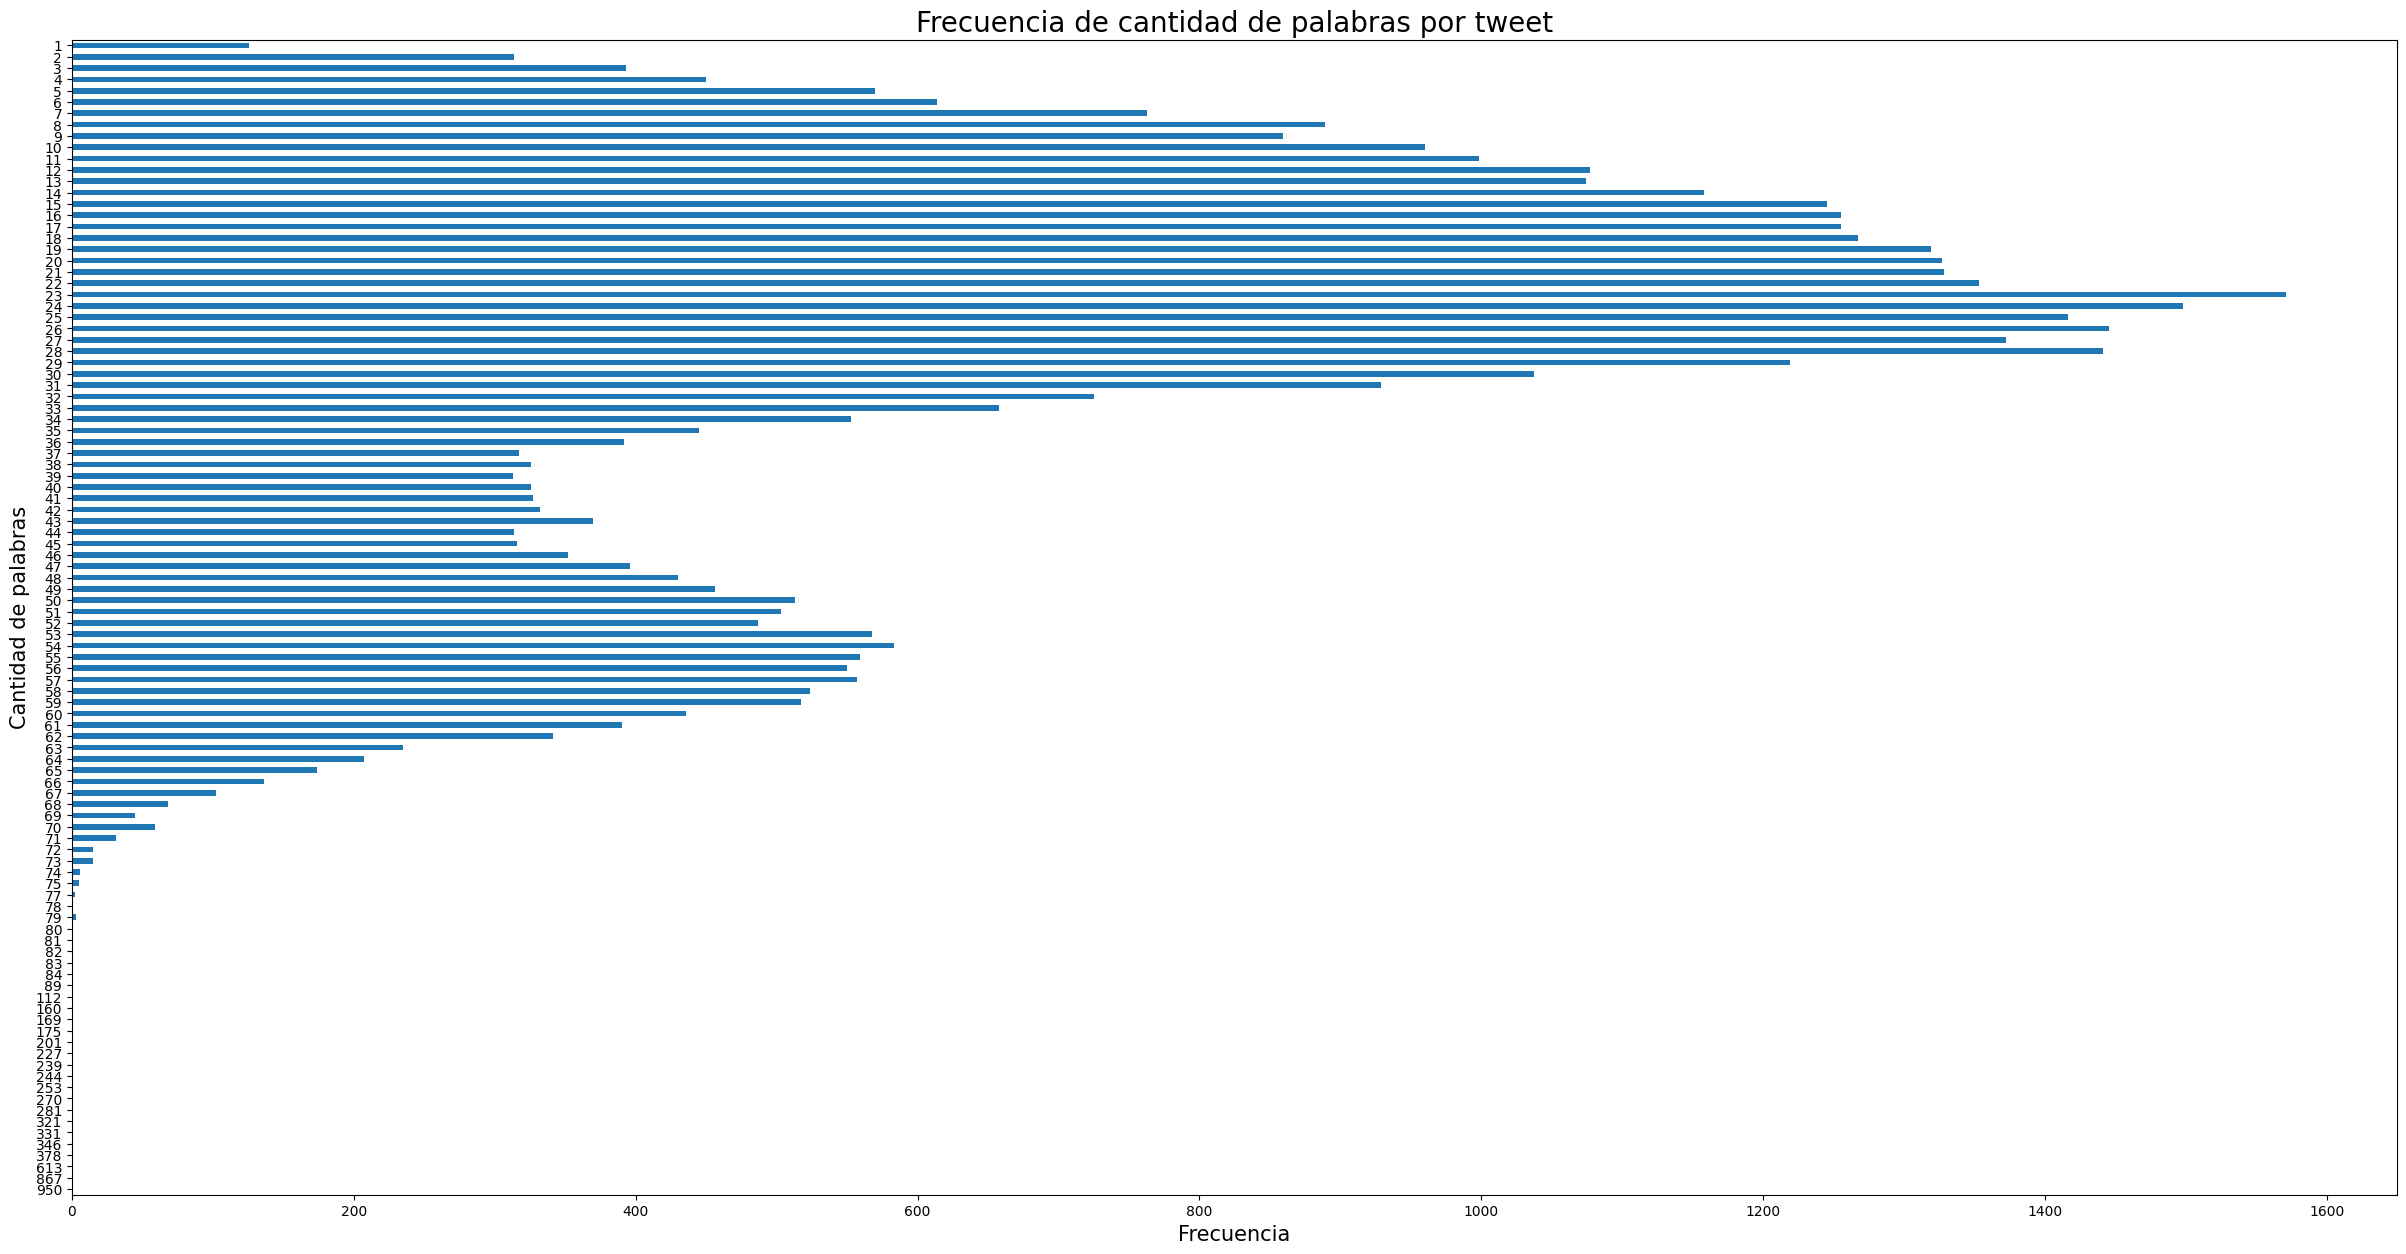

In [12]:
plt.figure(figsize=(30,15))

count_dic = {}
for idx,sentence in enumerate(nlp_docs):
    count_dic[idx] = len(sentence)

#print(pd.Series(count_dic).value_counts().sort_values(ascending=False))
pd.Series(count_dic).value_counts().sort_index(ascending=False).plot(kind="barh")
plt.title("Frecuencia de cantidad de palabras por tweet",size=20)
plt.xlabel("Frecuencia",size = 15)
plt.ylabel("Cantidad de palabras",size = 15)

#### Cómo tienen algunos tweets más de mil palabras? Fue por esta búsqueda que convierto los \r\n en espacio y convierto su count en característca antes de tokenizar

In [13]:
lis_long_tweets = dataset.loc[dataset["tweet_text"].str.len() >1000,"tweet_text"].tolist()
[x for x in lis_long_tweets]#\r\n parece ser un tweet diferente
lis_long_tweets[0]

'@EurekAlertAAAS: Researchers push to import top anti-bullying program to US schools http://t.co/UPZrMbl @NomCookiesNom Instead of personal attacks, maybe you can explain why there are more than 100 Islamic terrorist groups. @_Finessinfool yea i am going to bring in tomorrow #mkr I think Colin might not be a fan of the meatballs. @KatieBatterman yeah, we should talk. I was just about to send an email over to them right before I was told it was retracted. I am not a fan of the bears from QLD. 💩 #MKR @eDRoaCH @orvtech this is not de-anonymizing. the phone # would not necessarily be stored. no names would be required. @owlcity hey adam :) I have been to 2 of your concerts &amp; have not been allowed to meet you. when will I be able to? Me: The boat or the thing that melts Nazi faces? Watching a video of the snowman play from primary school! Go Tanners Wood haha #oldschool @eranubuwah @352_7538 Taking tiny villages while loosing major cities like Tikrit. Sofro Bulling No Chat u_u @greenlin

#### Revisaré ahora la Distribución de la variable objetivo

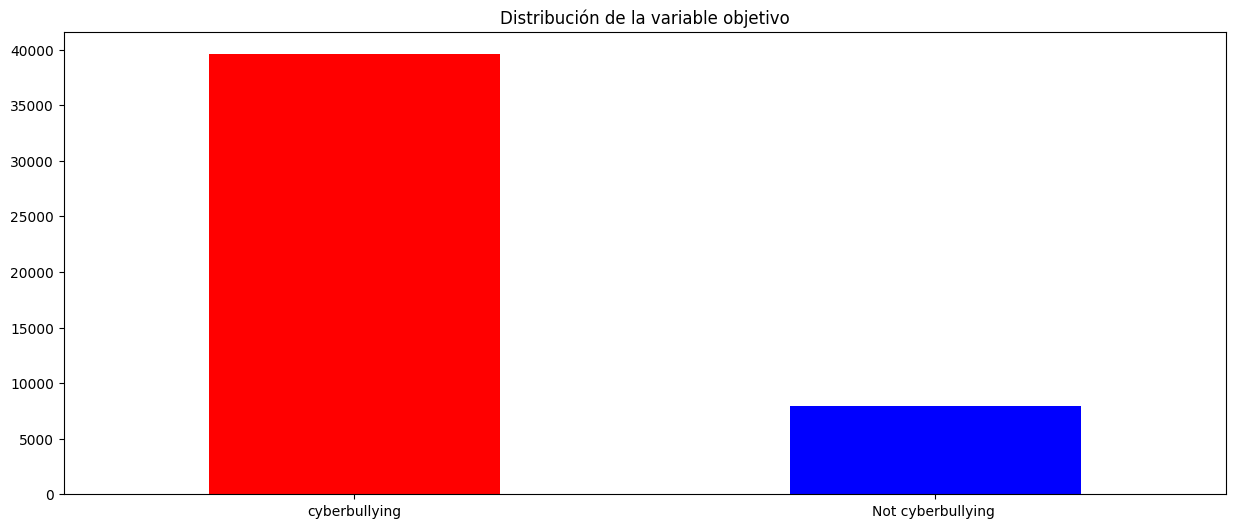

Este desbalance nos traerá problemas a la hora de levantar un modelo predictivo funcional


In [14]:
fig,ax = plt.subplots(figsize=(15,6))
etiquetas = dataset.cyberbullying.value_counts()
etiquetas.plot(kind= 'bar', color= ["red", "blue"])
ax.set_xticklabels(('cyberbullying', 'Not cyberbullying '),rotation=0)
plt.title('Distribución de la variable objetivo')

plt.show()
print("Este desbalance nos traerá problemas a la hora de levantar un modelo predictivo funcional")

#### Analizaré la frecuencia de algunas palabras utilizadas, removeré el ruido, obviando signos de puntiación, stopwords y me quedaré con los lemmas para pasarlos a minúscula, arreglar contracciones y eliminar espacios. Además estandarizaré cosas como urls y #´s.

In [15]:
import textacy
#import contractions

lista_nlp_tweets_SinStop_lemma = [[ii for ii in x if not ii.is_stop] for x in nlp_docs] ## Saco stopwords
lista_nlp_tweets_SinStop_lemma = [[ii for ii in x if not ii.is_punct] for x in lista_nlp_tweets_SinStop_lemma] ## Saco signos de puntuación
lista_nlp_tweets_SinStop_lemma = [[ii.lemma_ for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ##ii.lema sin _ da números
lista_nlp_tweets_SinStop_lemma = [[ii.lower() for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ## Dejo todo en minúscula
lista_nlp_tweets_SinStop_lemma = [[ii for ii in x if not ii == " "] for x in lista_nlp_tweets_SinStop_lemma] ## Saco los espacios


#Anteriormente arrega¡laba aquí las contractions, pero probablemente sea mejor hacerlo antes de pasar por el pipe de spacy
#lista_nlp_tweets_SinStop_lemma = [[contractions.fix(ii, slang=True) for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ## Arreglo slang y contractions que queden

def is_url(token):
    return token.startswith("https://") or token.startswith("http://") or token.startswith("www.")
lista_nlp_tweets_SinStop_lemma = [["URL" if is_url(ii) else ii for ii in x] for x in lista_nlp_tweets_SinStop_lemma]

                                  
lista_nlp_tweets_SinStop_lemma = [["MENTION" if ii.startswith("@") else ii for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ## Normalizo @s
lista_nlp_tweets_SinStop_lemma = [["HASHTAG" if ii.startswith("#") else ii for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ## Normalizo @s

lista_nlp_tweets_SinStop_lemma = [["NUMBER" if ii.isdigit() else ii for ii in x] for x in lista_nlp_tweets_SinStop_lemma] ## Normalizo números

dataset["tweet_lemma_NoStopwordNoPunct"] = lista_nlp_tweets_SinStop_lemma
dataset["tweet_lemma_NoStopwordNoPunct"] = dataset["tweet_lemma_NoStopwordNoPunct"].astype("O")
dataset["tweet_lemma_NoStopwordNoPunct"] = dataset["tweet_lemma_NoStopwordNoPunct"].apply(lambda x: str(x).replace("[","").replace("]","").replace("'",""))
dataset["tweet_lemma_NoStopwordNoPunct"] = dataset["tweet_lemma_NoStopwordNoPunct"].astype("O")
lista_nlp_tweets_SinStop_lemma = [ii for sublist in lista_nlp_tweets_SinStop_lemma for ii in sublist]
dict_words = {}
for idx, val in enumerate(lista_nlp_tweets_SinStop_lemma):
    dict_words[idx] = val

ser_words = pd.Series(dict_words)

#plt.xticks(rotation=90)

"""
#print(lista_nlp_tweets_SinStop_lemma)
#ser_freq.value_counts()
"""

'\n#print(lista_nlp_tweets_SinStop_lemma)\n#ser_freq.value_counts()\n'

Text(0, 0.5, 'Lemmas')

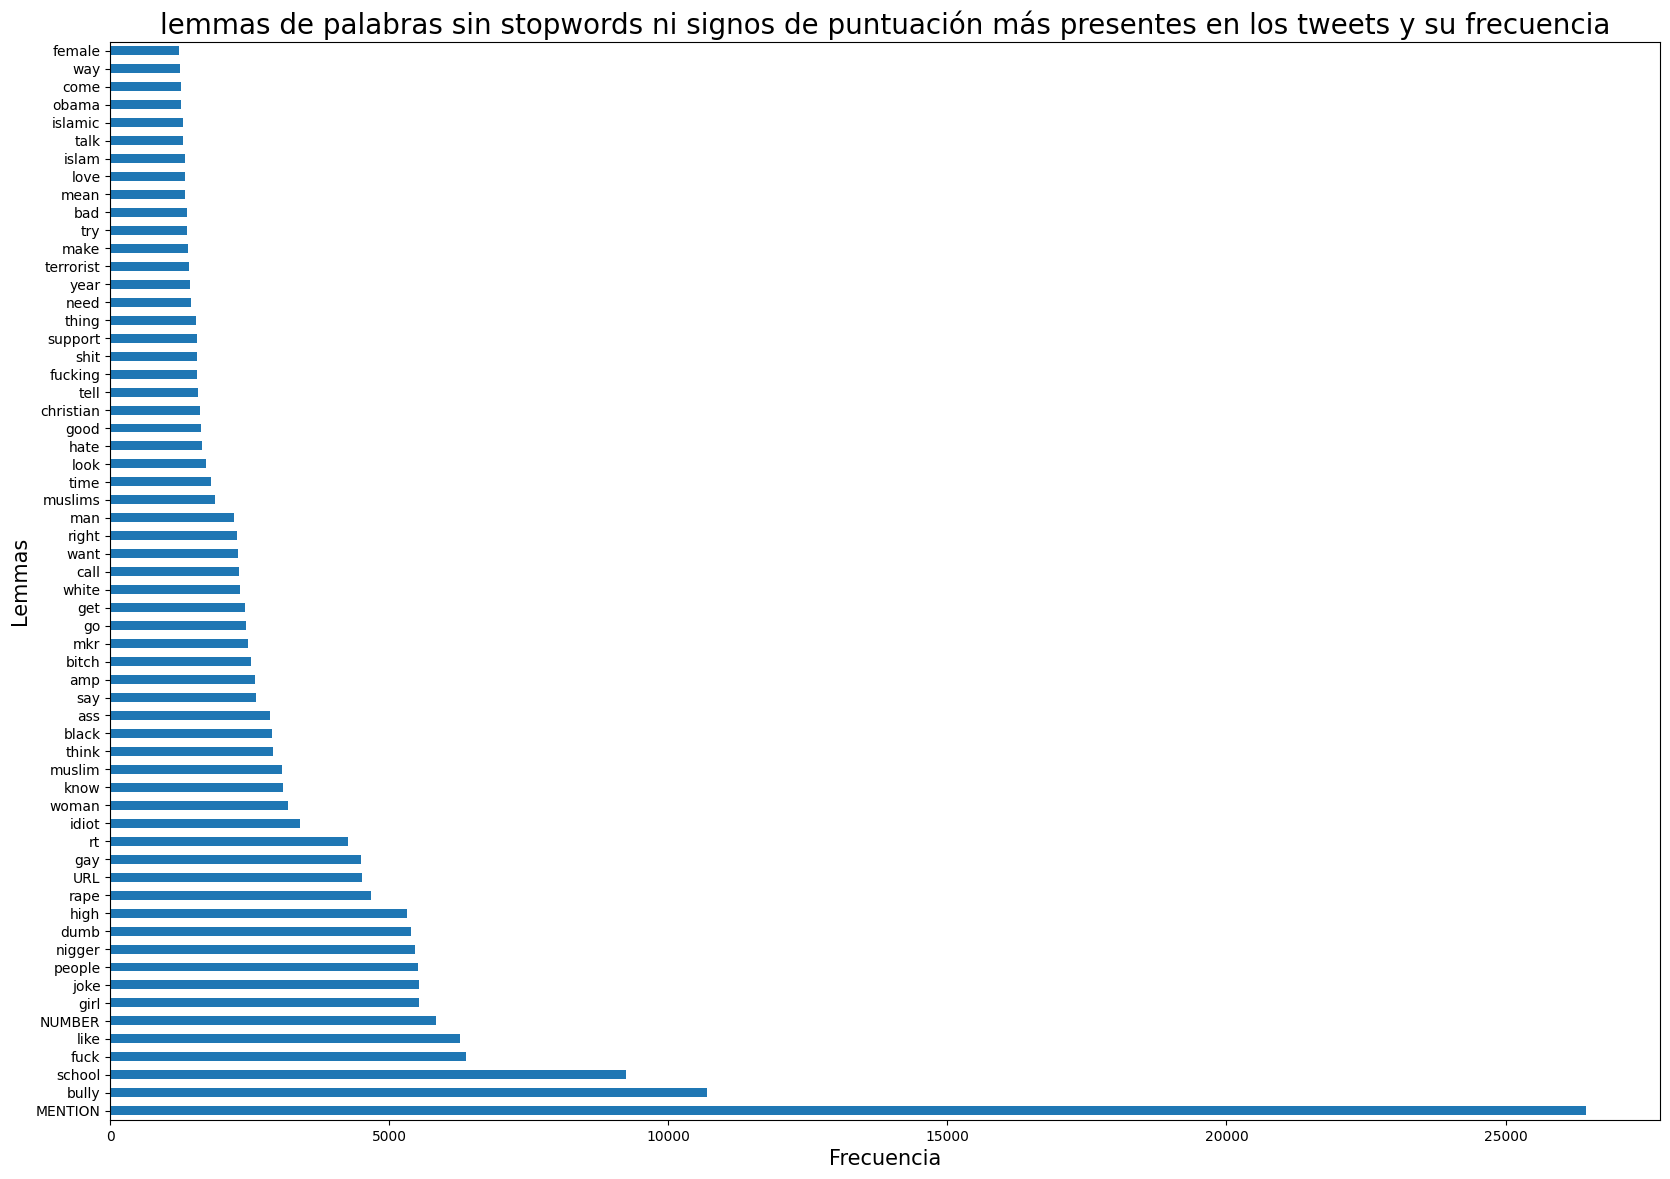

In [16]:
#ser_words.value_counts().plot(kind="barh")
ax, fig = plt.subplots(figsize=(20,14))
ser_words.value_counts().head(40)
ser_words.value_counts(ascending=False).head(60).plot(kind="barh")
plt.title("lemmas de palabras sin stopwords ni signos de puntuación más presentes en los tweets y su frecuencia",size=20)
plt.xlabel("Frecuencia",size = 15)
plt.ylabel("Lemmas",size = 15)


#### Analizo diferencias en la longitud de tweets con y sin bullying

Text(0, 0.5, 'Densidad')

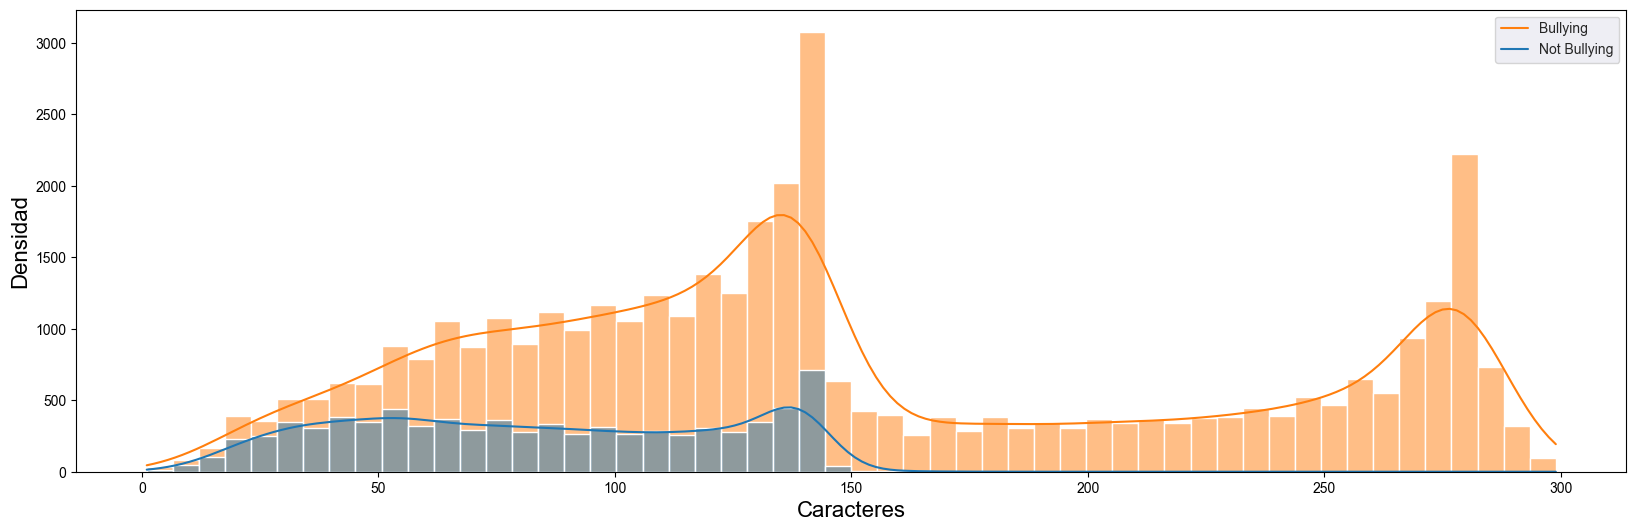

In [17]:
# Importamos las librerías matplotlib y seaborn:
dataset["char_len"] = dataset["tweet_text"].apply(lambda x: len(x))



ax, fig = plt.subplots(figsize=(20,6))
sns.set_style("darkgrid")

sns.histplot(data=dataset.loc[dataset["tweet_text"].str.len() <300,], x="char_len", hue="cyberbullying", kde=True, legend=True)
plt.legend(["Bullying", "Not Bullying"])
# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

#### Aún dejando el límite en 160 caracteres se ve una clara diferencia de medias

<AxesSubplot: xlabel='char_len', ylabel='cyberbullying'>

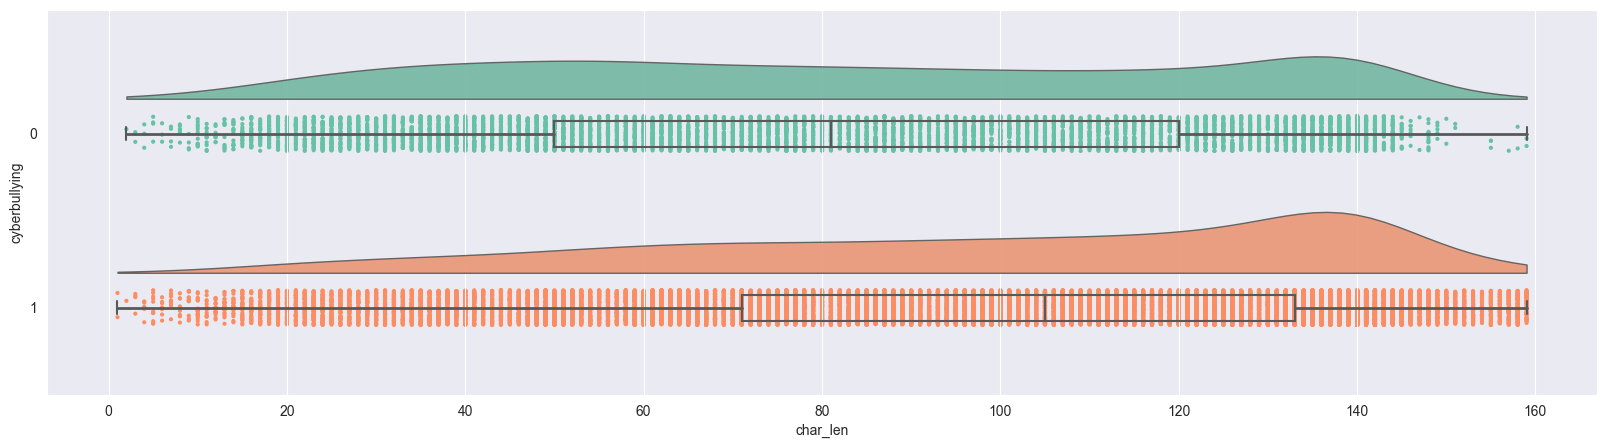

In [18]:
f, ax = plt.subplots(figsize=(20, 5))
pt.RainCloud(x = "cyberbullying", y ="char_len", data = dataset.loc[dataset["tweet_text"].str.len() <160,],
             width_viol = .7, orient = "h" , alpha = .9, dodge = False, pointplot = False)


### Character lenght será una varible muy valiosa a la hora de predecir si Bullyin o no.
### char_len Not Bullying parece seguir una distribución uniforme con un pequeño pico en 150. Pero al hablar de Bullying podemos ver fácilmente que tiene mucha más curtosis, estando la mayoría de sus observaciones centradas en 150.

### Sólo las instancias de Bullying pasan de 150n caracteres, aún no sé si sobrepasarse es un error del scraping de datos que se llevó a cabo.

# Pasaré ahora a analizar la calidad gramática de los tweets y a añadirlo como característica

In [19]:
from spellchecker import SpellChecker

In [20]:
spell = SpellChecker()
x = dataset.tweet_text[0].split(" ")
spell.unknown(x)

{'#katandandre,', '#mkr', 'crapilicious!'}

In [21]:
spell = SpellChecker()

def amount_misspelled(ser,amount):
    wordlist=ser.split()
    
    amount_miss = len(list(spell.unknown(wordlist)))
    percentage_misspelled= amount_miss/len(wordlist)
    if amount:
        return amount_miss
    else:
        return percentage_misspelled
   
dataset["amount_misspelled_words"] = dataset.tweet_text.apply(lambda x: amount_misspelled(x,amount=True))
dataset["percentage_misspelled_words"] = dataset.tweet_text.apply(lambda x: amount_misspelled(x,amount=False))

In [22]:
dataset.tweet_text.apply(lambda x: amount_misspelled(x,True))

0         3
1        11
2         3
3         5
4         6
         ..
47687     6
47688     8
47689     7
47690     5
47691     5
Name: tweet_text, Length: 47526, dtype: int64

In [23]:
dataset["amount_misspelled_words"].describe()

count    47526.000000
mean         4.773661
std          3.434535
min          0.000000
25%          3.000000
50%          4.000000
75%          6.000000
max        196.000000
Name: amount_misspelled_words, dtype: float64

<AxesSubplot: xlabel='amount_misspelled_words', ylabel='cyberbullying'>

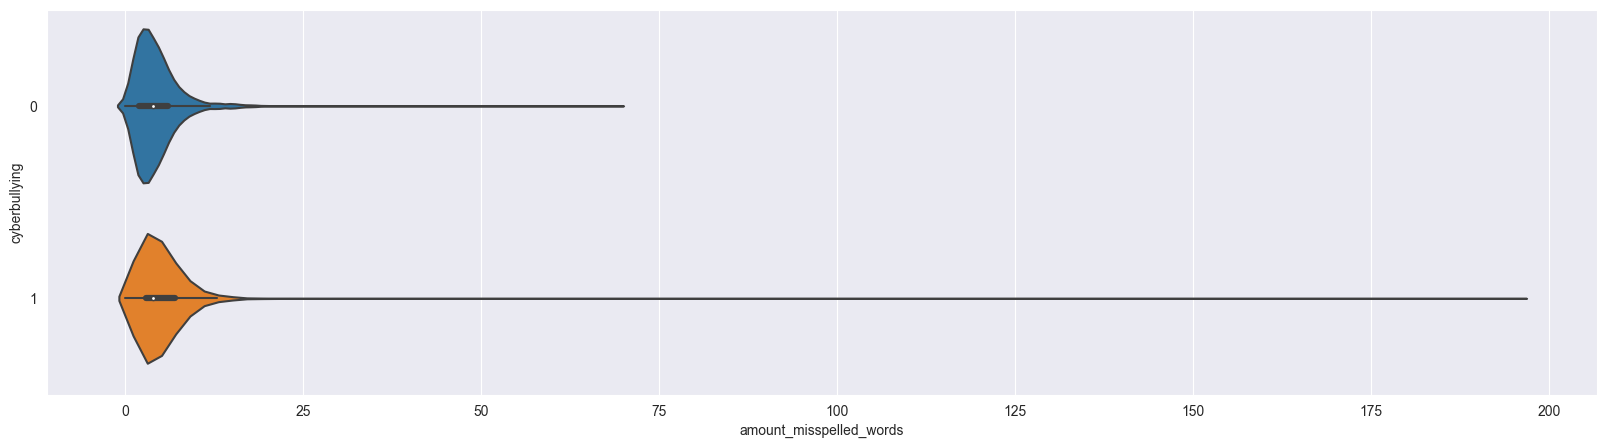

In [24]:
f, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="amount_misspelled_words",y="cyberbullying",data= dataset,orient="h")

<AxesSubplot: xlabel='percentage_misspelled_words', ylabel='cyberbullying'>

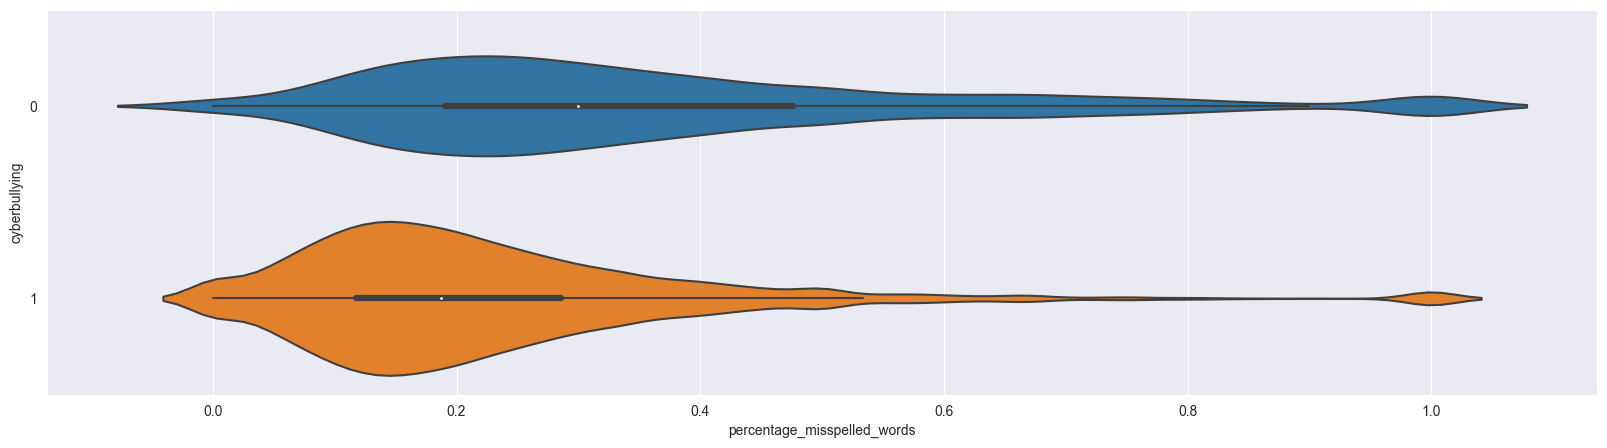

In [25]:
f, ax = plt.subplots(figsize=(20, 5))
sns.violinplot(x="percentage_misspelled_words",y="cyberbullying",data= dataset,orient="h")

## Analizaré ahora las diferentes palabras usadas en tweets con y sin bulllying

In [26]:
from wordcloud import WordCloud

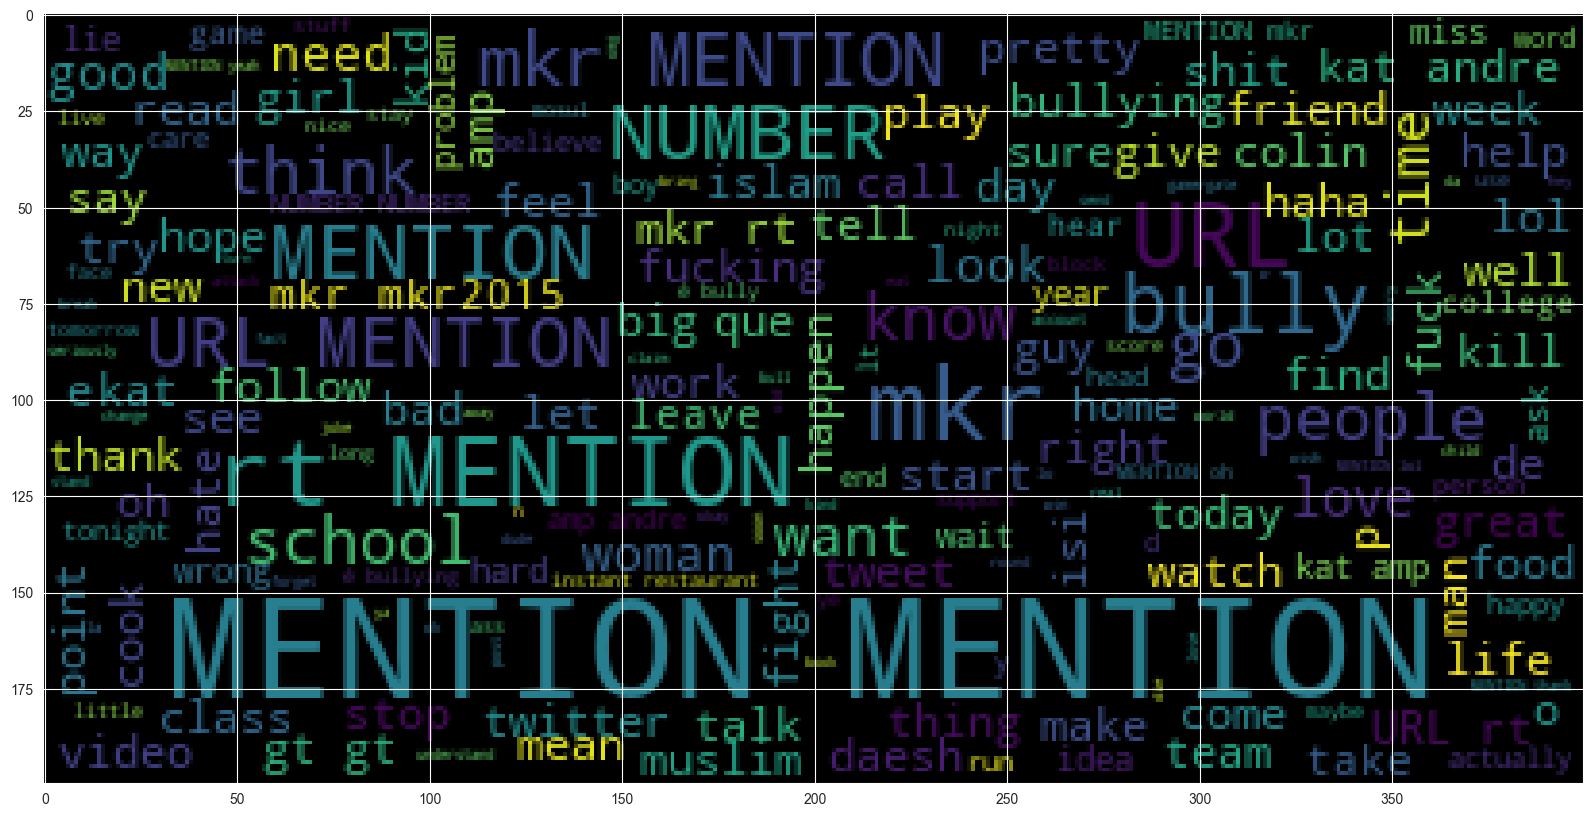

In [27]:
ax, fig = plt.subplots(figsize=(30,10))
wordcloud = WordCloud()
txt_cat0 = ",".join(dataset[dataset.cyberbullying==0].tweet_lemma_NoStopwordNoPunct.to_list())
plt.imshow(wordcloud.generate("".join(txt_cat0)))


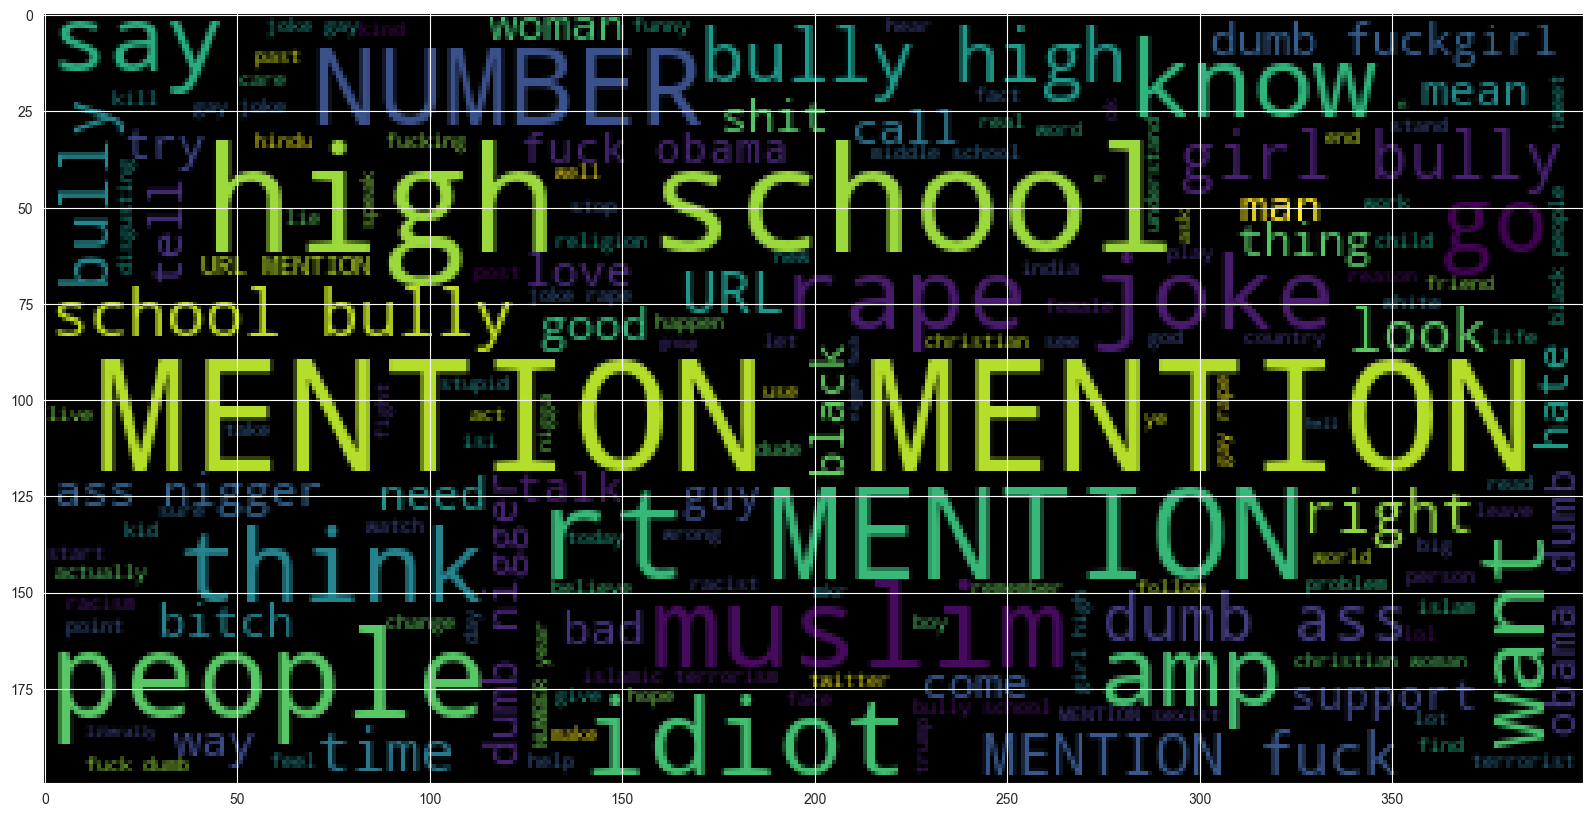

In [28]:
ax, fig = plt.subplots(figsize=(30,10))
wordcloud = WordCloud()
txt_cat1 = ",".join(dataset[dataset.cyberbullying==1].tweet_lemma_NoStopwordNoPunct.to_list())
plt.imshow(wordcloud.generate("".join(txt_cat1)))


## MKR aparece muy grande en los 0s y no en los 1s. MENTION es por mucho el token más utilizado Investiguemos. Esta investigación se llevará a cabo a partir de un dataframe undersampled para que la comparación sea justa.

In [31]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=123)
X_res, y_res = rus.fit_resample(dataset.drop("cyberbullying",axis=1), dataset.cyberbullying)
dataset_rus = pd.merge(X_res, y_res,left_index=True,right_index=True)

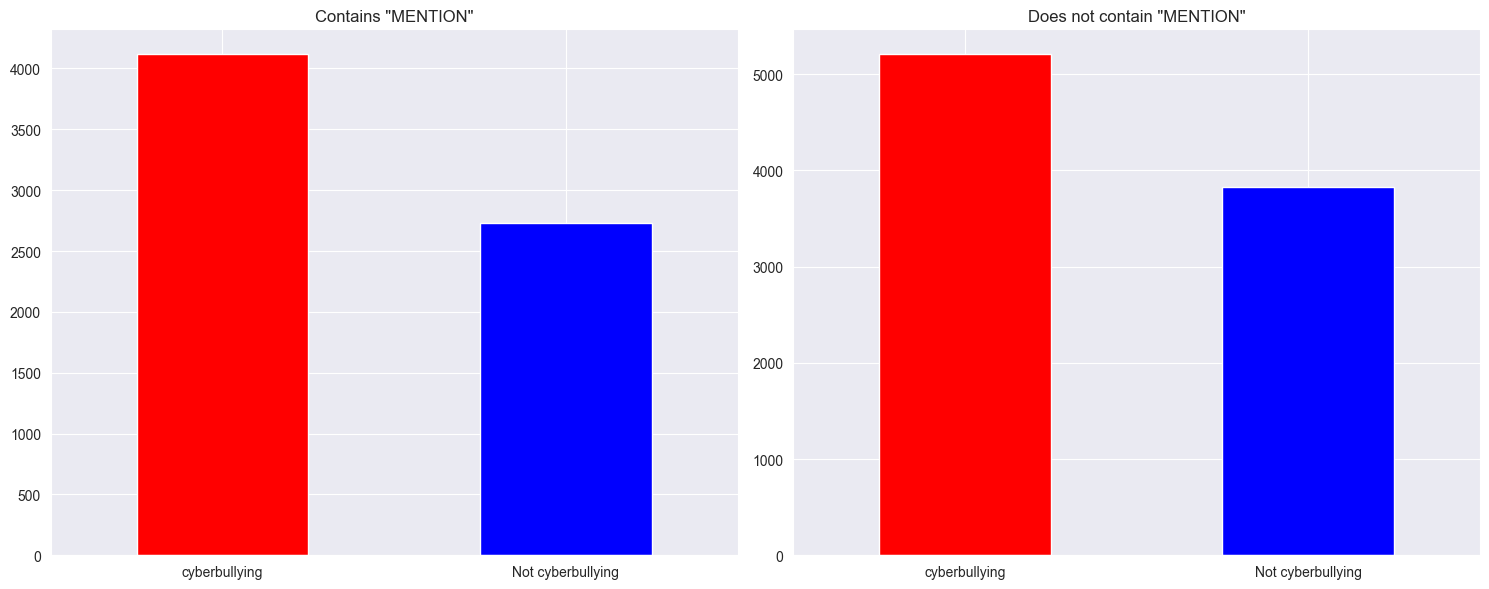

In [32]:
dataset_contains_MENTION = dataset_rus.loc[dataset_rus["tweet_lemma_NoStopwordNoPunct"].str.contains("MENTION")]
dataset_Notcontains_MENTION= dataset_rus.loc[~dataset_rus["tweet_lemma_NoStopwordNoPunct"].str.contains("MENTION")]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))


dataset_contains_MENTION = dataset_contains_MENTION.cyberbullying.value_counts()
dataset_contains_MENTION.plot(kind='bar', color=["red", "blue"], ax=ax[0])
ax[0].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
ax[0].set_title('Contains "MENTION"')

dataset_Notcontains_MENTION = dataset_Notcontains_MENTION.cyberbullying.value_counts()
dataset_Notcontains_MENTION.plot(kind='bar', color=["red", "blue"], ax=ax[1])
ax[1].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
ax[1].set_title('Does not contain "MENTION"')

# Show the plots
plt.tight_layout()
plt.show()



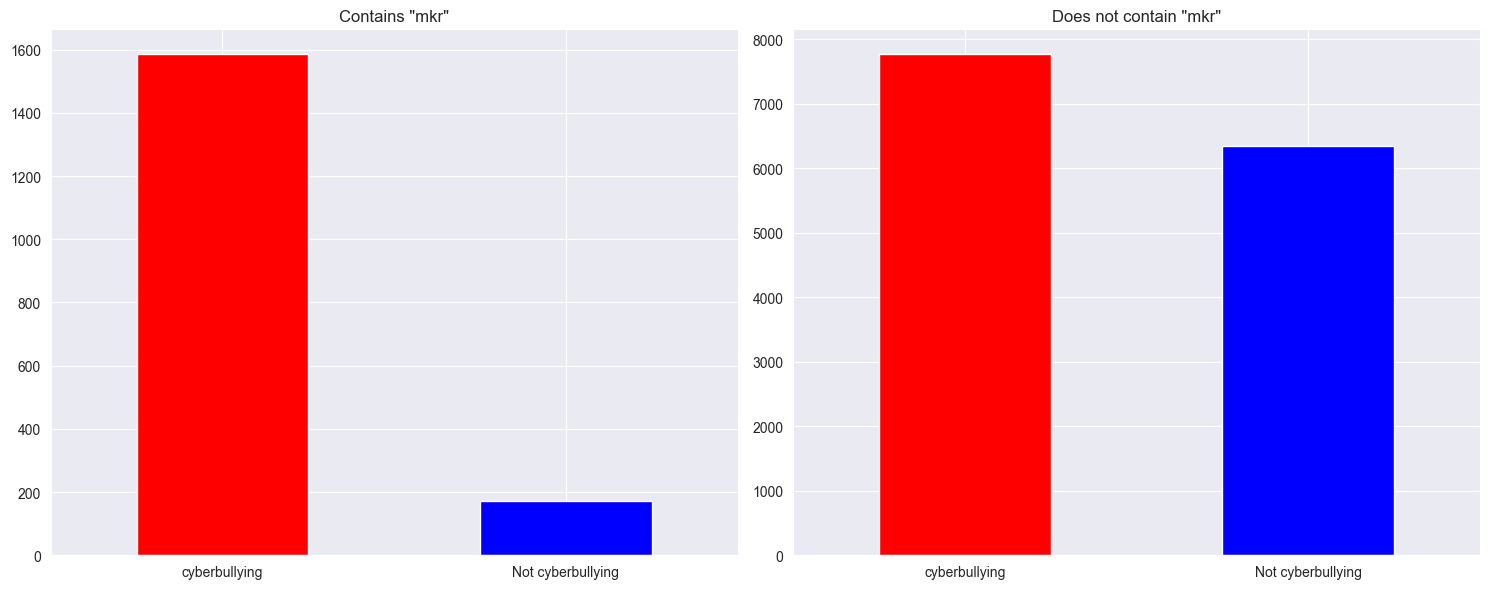

In [33]:
dataset_contains_mkr = dataset_rus.loc[dataset_rus["tweet_text"].str.lower().str.contains("mkr")]
dataset_Notcontains_mkr= dataset_rus.loc[~dataset_rus["tweet_text"].str.lower().str.contains("mkr")]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))


etiquetas_contains_mkr = dataset_contains_mkr.cyberbullying.value_counts()
etiquetas_contains_mkr.plot(kind='bar', color=["red", "blue"], ax=axs[0])
axs[0].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
axs[0].set_title('Contains "mkr"')

etiquetas_Notcontains_mkr = dataset_Notcontains_mkr.cyberbullying.value_counts()
etiquetas_Notcontains_mkr.plot(kind='bar', color=["red", "blue"], ax=axs[1])
axs[1].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
axs[1].set_title('Does not contain "mkr"')

# Show the plots
plt.tight_layout()
plt.show()



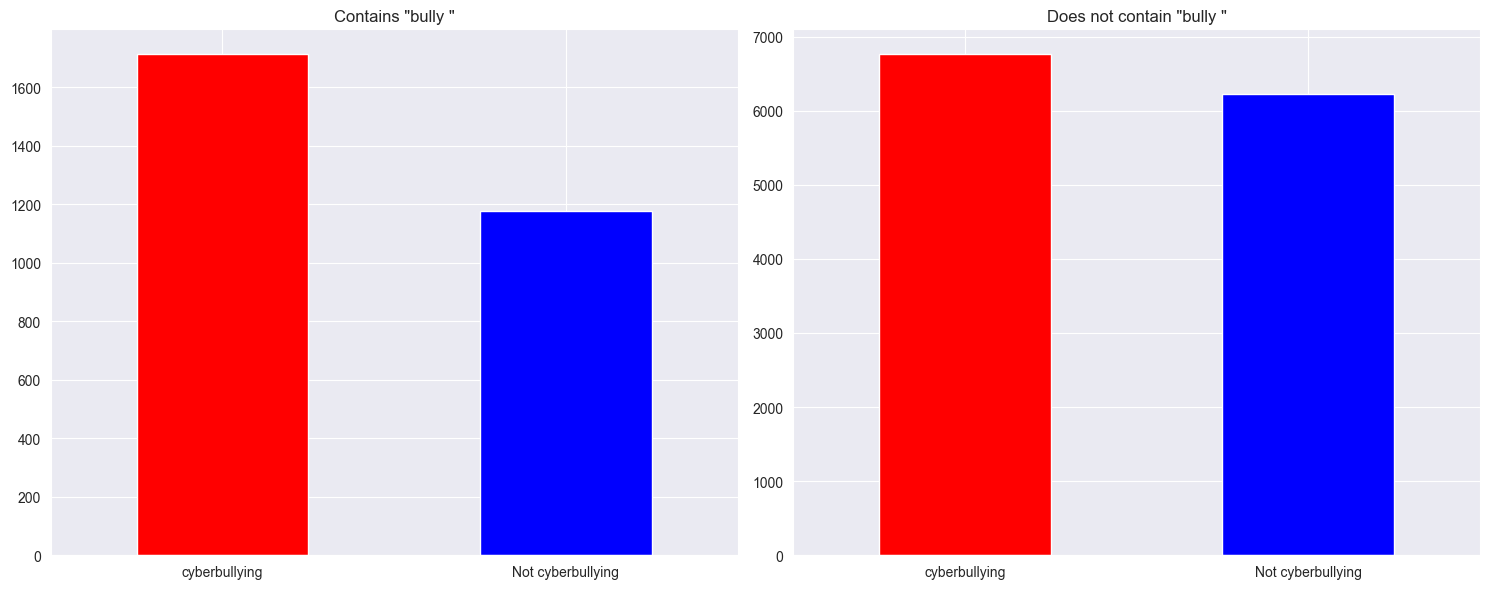

In [34]:
dataset_contains_bully = dataset_rus.loc[dataset_rus["tweet_lemma_NoStopwordNoPunct"].str.contains("bully")]
dataset_Notcontains_bully = dataset_rus.loc[~dataset_rus["tweet_lemma_NoStopwordNoPunct"].str.contains("bully")]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))


dataset_contains_bully = dataset_contains_bully .cyberbullying.value_counts()
dataset_contains_bully .plot(kind='bar', color=["red", "blue"], ax=ax[0])
ax[0].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
ax[0].set_title('Contains "bully "')

dataset_Notcontains_bully  = dataset_Notcontains_bully.cyberbullying.value_counts()
dataset_Notcontains_bully.plot(kind='bar', color=["red", "blue"], ax=ax[1])
ax[1].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
ax[1].set_title('Does not contain "bully "')

# Show the plots
plt.tight_layout()
plt.show()



### Tokens con que aparecen con diferencia en ambas categorías, las añadiré posteripormente como categorías

### Encontré el paquete profanity_check, da un score del 0 al 1 de probabilidad de contener una mala palabra, lo probé con todas las palabras que se ven en el wordcloud de cyberbullying==1 y todas las identifica correctamente, dejo evidencia sólo de idiot para no llenar la tarea de vulgaridades.

In [35]:
from profanity_check import predict, predict_prob

In [36]:
print(dataset.tweet_text[0])
print(predict_prob([dataset.tweet_text[0]]))
predict_prob(["idiot"])

In other words #katandandre, your food was crapilicious! #mkr
[0.02775964]


array([0.99999865])

In [37]:
dataset["profanity_prob"] = dataset.tweet_text.apply(lambda x: predict_prob([x])[0])
dataset["profanity_prob"]

0        0.027760
1        0.119825
2        0.851390
3        0.268758
4        0.369320
           ...   
47687    0.065887
47688    0.254219
47689    1.000000
47690    1.000000
47691    1.000000
Name: profanity_prob, Length: 47526, dtype: float64

## Ya tengo capturado el efecto de ciertas palabras muy clave, de palabras negativas y de aquellas mal escritas. Haré ahora una lista de las palabras positivas que más parecen estar contenidas en cyberbullying==0 para tomar en cuenta ese efecto

In [38]:
def relation_word_cyberbullying(dataset,palabra,column="tweet_lemma_NoStopwordNoPunct"):
    dataset_contains_MENTION = dataset.loc[dataset[column].str.contains(palabra)]
    dataset_Notcontains_MENTION= dataset.loc[~dataset[column].str.contains(palabra)]
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    
    dataset_contains_MENTION = dataset_contains_MENTION.cyberbullying.value_counts()
    dataset_contains_MENTION.plot(kind='bar', color=["red", "blue"], ax=ax[0])
    ax[0].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
    ax[0].set_title(f"Contains {palabra}")
    
    dataset_Notcontains_MENTION = dataset_Notcontains_MENTION.cyberbullying.value_counts()
    dataset_Notcontains_MENTION.plot(kind='bar', color=["red", "blue"], ax=ax[1])
    ax[1].set_xticklabels(('cyberbullying', 'Not cyberbullying'), rotation=0)
    ax[1].set_title(f"Does not contain {palabra}")
    
    # Show the plots
    plt.tight_layout()
    plt.show()


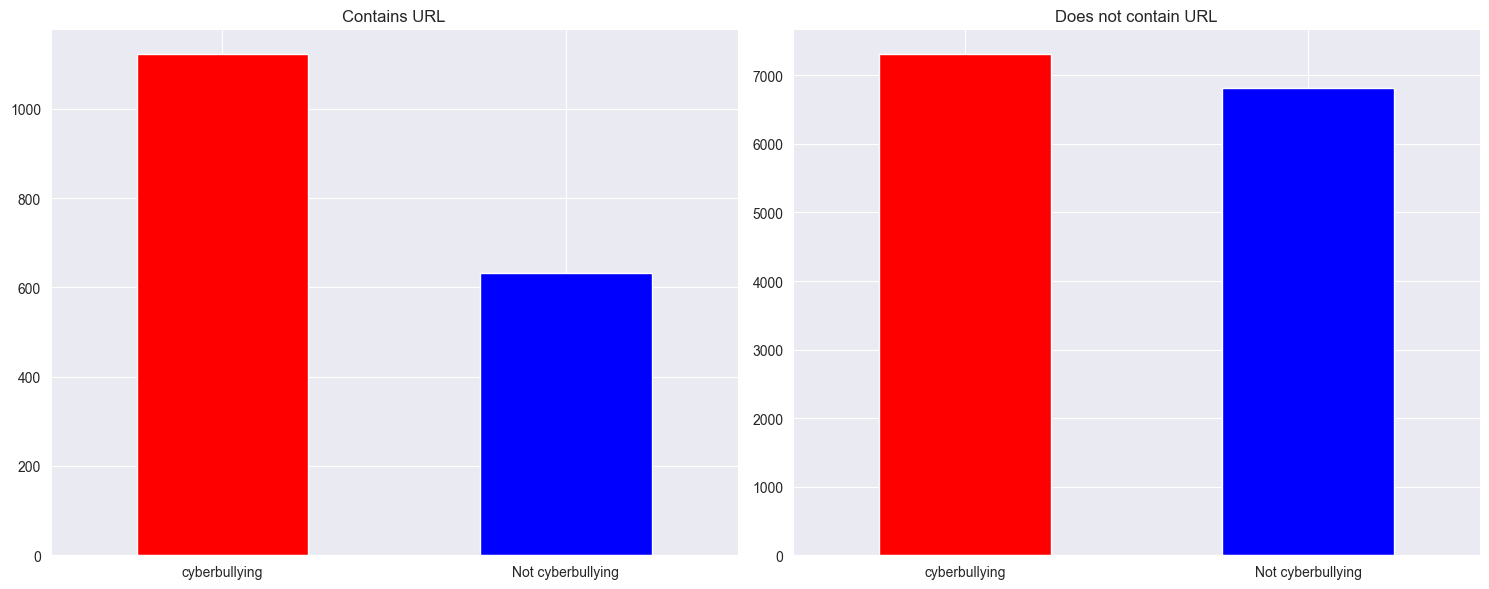

In [39]:
relation_word_cyberbullying(dataset_rus,"URL")
plt.show()
# No encontré nada muy significativo a mano más allá de las previamente mencionadas y URL

### Tuve la idea de implementar un análisis de entidades en los tweets, no me dio frutos más allá de cantidad de entidades presentes

In [40]:
dataset["entities"] = dataset.tweet_text_doc.apply(lambda x: [x for x in list(x.ents)] )
dataset["entity_labes"] = dataset.tweet_text_doc.apply(lambda x: [x.label_ for x in list(x.ents)])
dataset["amount_entities"] = dataset.entity_labes.apply(lambda x: len(x))

#### Paso las palabras con distibución diferenciada a característica

In [41]:
dataset["amount_url"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"URL")) 
dataset["amount_mention"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"MENTION")) 
dataset["amount_number"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"NUMBER")) 
dataset["amount_hashtag"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"HASHTAG")) 
dataset["amount_mkr"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"mkr")) 
dataset["amount_bully"] =dataset.tweet_text.apply(lambda x:count_slashes(x,"bully")) 


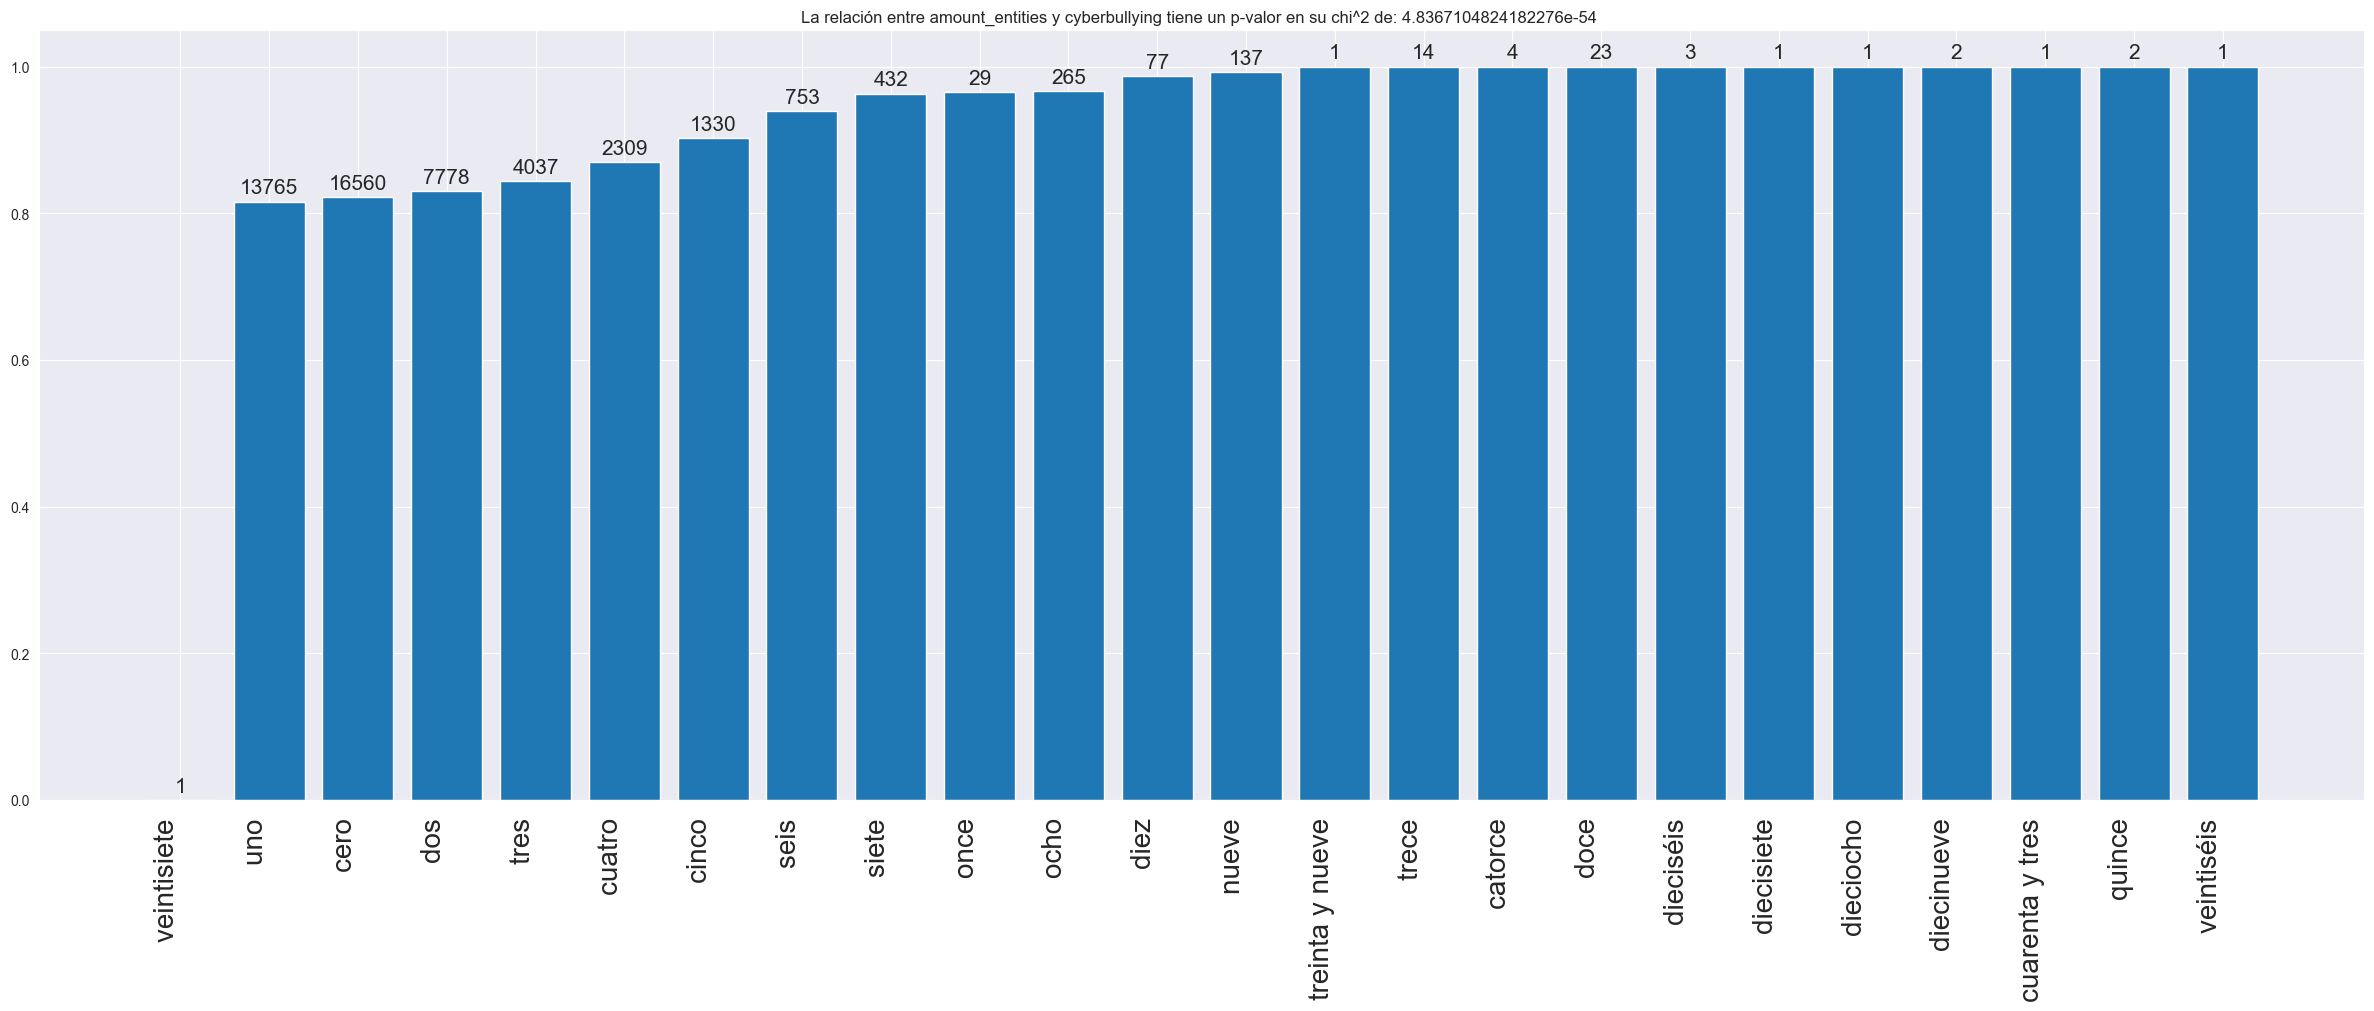

In [42]:
jd.grafica_relacion_cat_obj(dataset, "amount_entities","cyberbullying", to_words=True,order=True, dame_chi_cuadrado = True,size=(30,10))


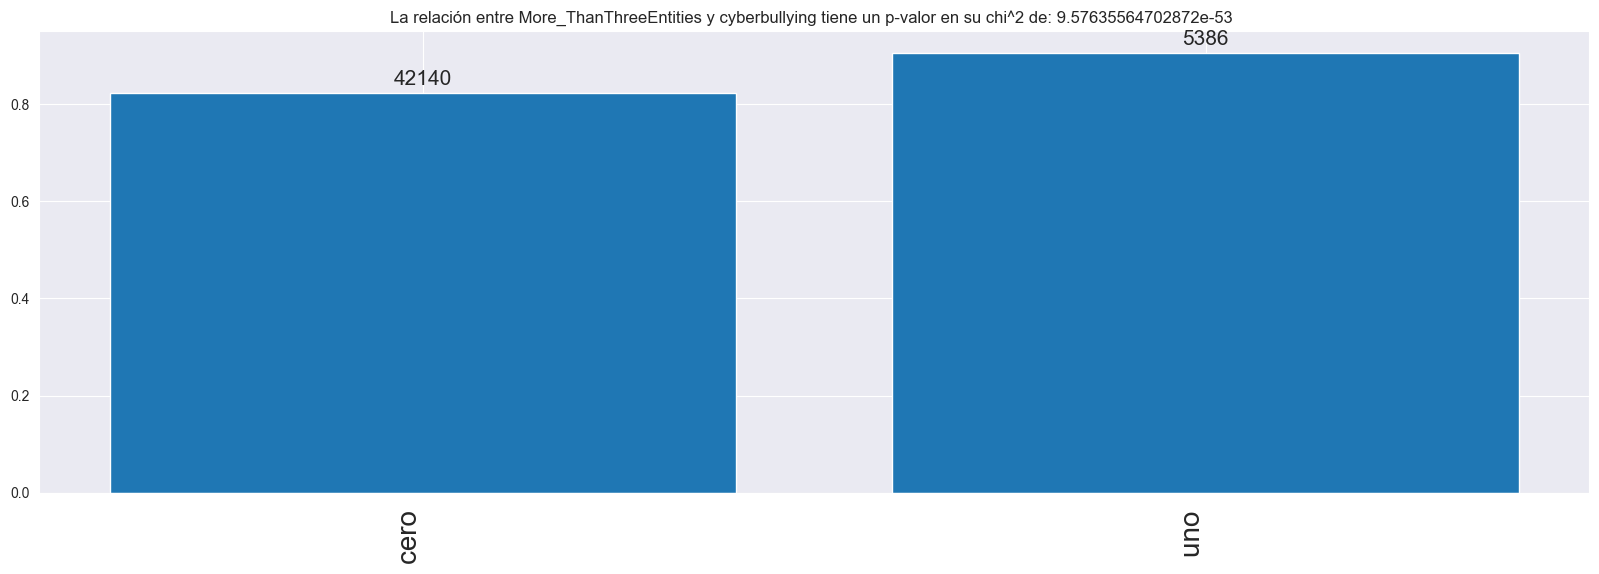

In [43]:
dataset["More_ThanThreeEntities"] = dataset.amount_entities.apply(lambda x: 0 if x <=3 else 1)

jd.grafica_relacion_cat_obj(dataset, "More_ThanThreeEntities","cyberbullying",to_words = True,
                            dame_chi_cuadrado=True, size=(20,6))



#### More than 3 entities parece ser buena característica. Tiene inclusive un p-valor significativo

In [44]:
"""
Intento fallido, devuelve lista de sets que son todos valores únicos

dataset_cyberbullying1 = dataset[dataset["cyberbullying"]==1]
dataset_cyberbullying0 = dataset[dataset["cyberbullying"]==0]

ax, fig = plt.subplots(figsize=(20,14))
dataset_cyberbullying1[dataset_cyberbullying1["entities"].str.len() !=0].entities.value_counts().head(60).plot(kind="barh")
plt.title("Frecuencia de entidades en tweets con bullying",size=20)
plt.xlabel("Frecuencia",size = 15)
plt.ylabel("Entidades",size = 15)
"""

'\nIntento fallido, devuelve lista de sets que son todos valores únicos\n\ndataset_cyberbullying1 = dataset[dataset["cyberbullying"]==1]\ndataset_cyberbullying0 = dataset[dataset["cyberbullying"]==0]\n\nax, fig = plt.subplots(figsize=(20,14))\ndataset_cyberbullying1[dataset_cyberbullying1["entities"].str.len() !=0].entities.value_counts().head(60).plot(kind="barh")\nplt.title("Frecuencia de entidades en tweets con bullying",size=20)\nplt.xlabel("Frecuencia",size = 15)\nplt.ylabel("Entidades",size = 15)\n'

## Incorporaré el vader_lexicon de nltk para incorporar aún más información con la que alimentar a mi modelo predictivo.

In [45]:
#nltk.download('vader_lexicon')

In [46]:
dataset.columns

Index(['tweet_text', 'cyberbullying', 'cantidad_retorno_carro_newline',
       'tweet_text_doc', 'tweet_lemma_NoStopwordNoPunct', 'char_len',
       'amount_misspelled_words', 'percentage_misspelled_words',
       'profanity_prob', 'entities', 'entity_labes', 'amount_entities',
       'amount_url', 'amount_mention', 'amount_number', 'amount_hashtag',
       'amount_mkr', 'amount_bully', 'More_ThanThreeEntities'],
      dtype='object')

In [47]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid =SentimentIntensityAnalyzer()

dataset["negative_sentiment_score"] = dataset.tweet_text.apply(lambda x: sid.polarity_scores(x)["neg"] )
dataset["positive_sentiment_score"] = dataset.tweet_text.apply(lambda x: sid.polarity_scores(x)["pos"] )
dataset["neutral_sentiment_score"] = dataset.tweet_text.apply(lambda x: sid.polarity_scores(x)["neu"] )
dataset["neutral_sentiment_score"] = dataset.tweet_text.apply(lambda x: sid.polarity_scores(x)["compound"] )

## Matriz de asociación de cramer, normalmente la pinto con seaborn, pero me está dando el problema que muestro a continuación, como sustituto la matriz de confusión de sklearn.

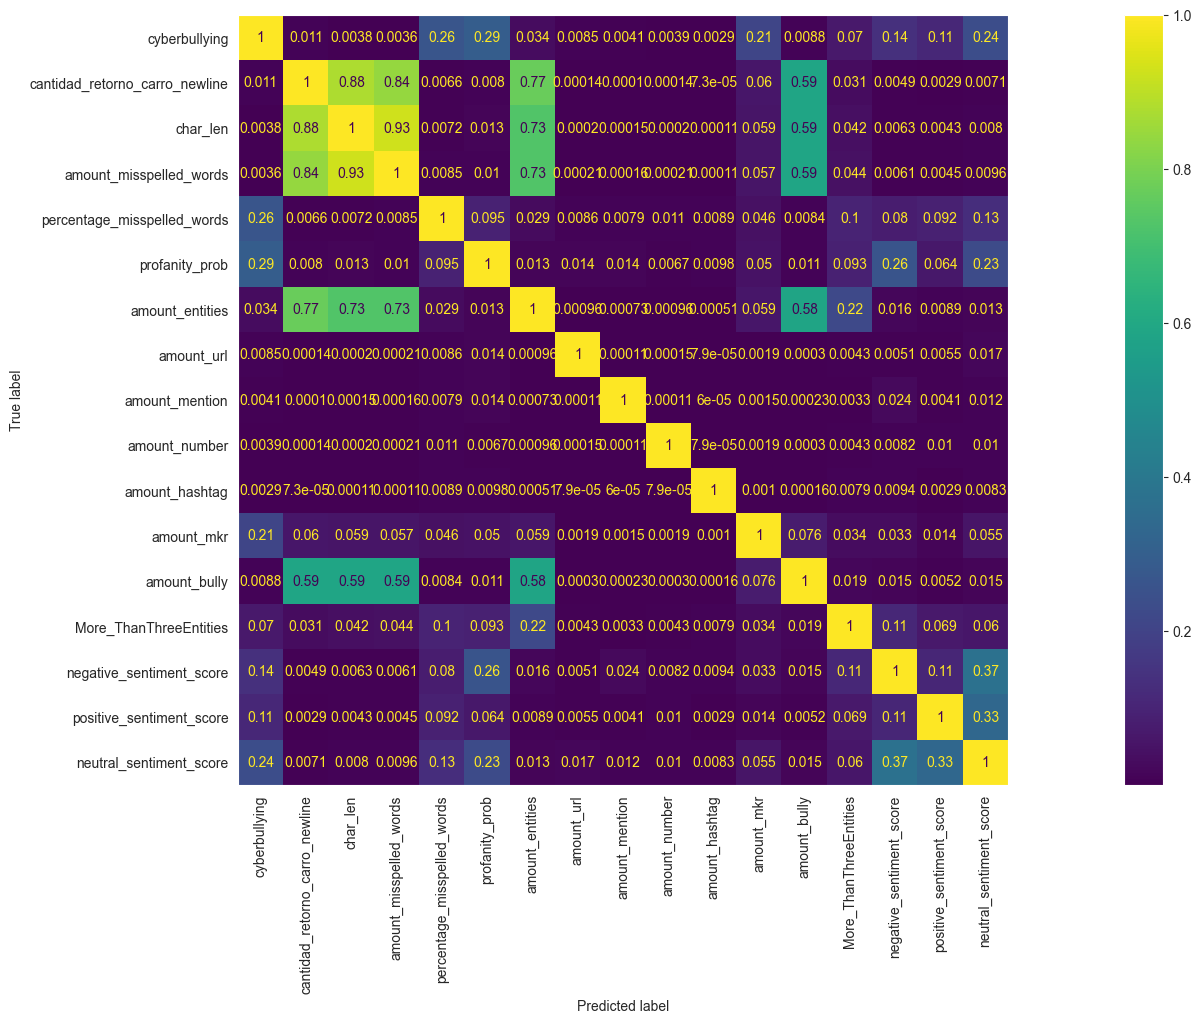

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

mat=jd.get_cat_corr_mat(dataset)
#sns.heatmap(mat.to_numpy(),annot =True)

disp = ConfusionMatrixDisplay(confusion_matrix=mat.to_numpy(),
                              display_labels=mat.select_dtypes(exclude = "object").columns)

                                              
fig, ax = plt.subplots(figsize=(30, 10))
disp.plot(ax=ax)
plt.xticks(rotation=90)
ax.grid(False)
plt.show()

### Problemas de correlación con bully, cantidad de mispelled words, cantidad entities, char_len. Todas además con baja asociación con la objetivo. Las otras columnas con entidades no fueron de mucha ayuda. Se les hará drop a todas estas

In [49]:
dataset.drop(["amount_bully","amount_misspelled_words","amount_entities","entities",
              "entity_labes"],axis=1,inplace=True)

### Gracias a Dios logré solucionar el problema con el heatmap de seaborn, era por una versión de matplotlib.

### Dejo que la fuerte asociación cramer entre char_len y cantidad_retorno_carro_newline entren en el modelo porque revisándolo, veo que dejando ambas variables se mejora la cantidad de acertados de la clase minoritaria.

<AxesSubplot: >

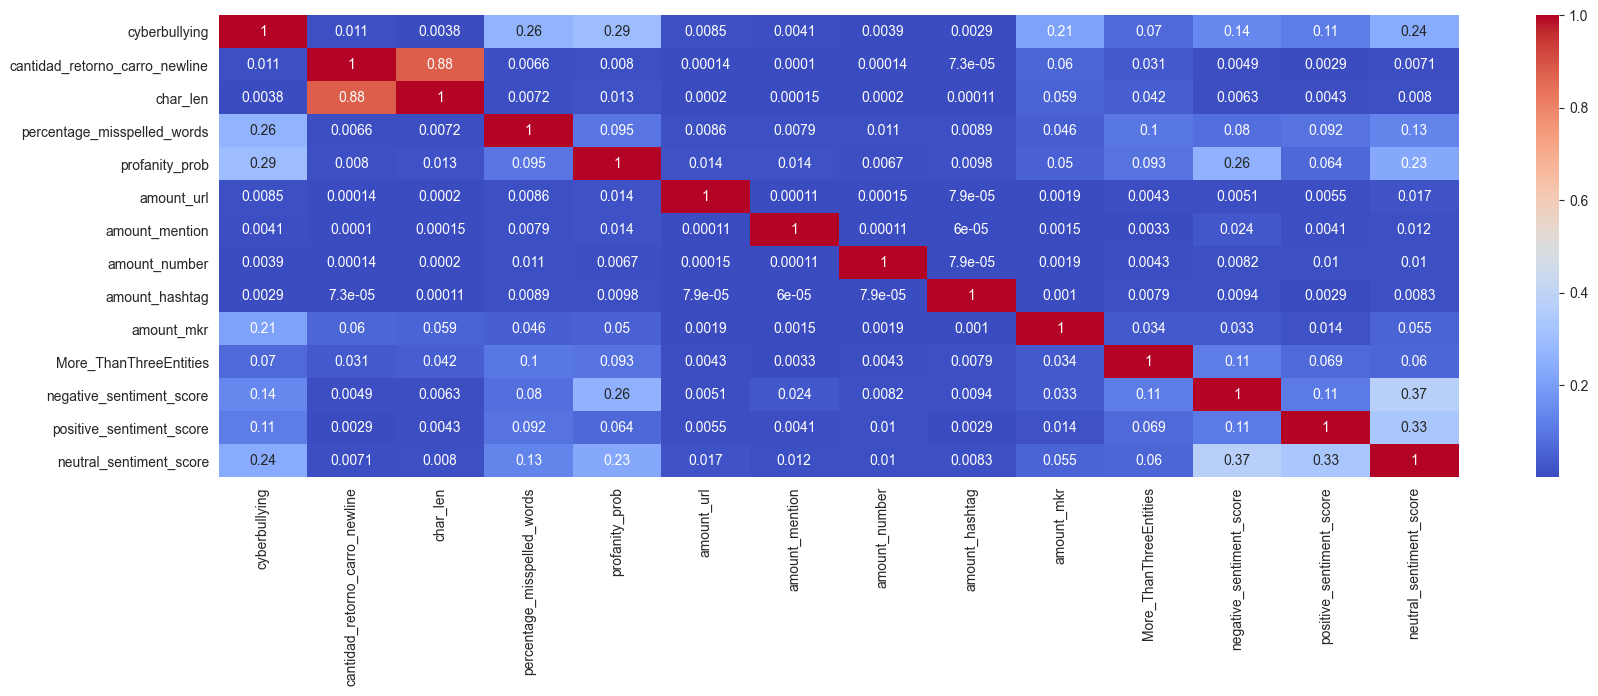

In [50]:
plt.figure(figsize=(20,6))
mat=jd.get_cat_corr_mat(dataset)
sns.heatmap(mat,cmap="coolwarm",annot = True)

In [51]:
import gensim.downloader as api
glove_emb = api.load('glove-twitter-25') # Descargamos y cargamosel embedding de "glove-twitter-25"

In [52]:
from nltk.tokenize import TweetTokenizer
# Tokenizar los tweets con el tokenizador "TweetTokenizer" de NLTK
def tokenize(texto):
  tweet_tokenizer = TweetTokenizer()
  tokens_list = tweet_tokenizer.tokenize(texto)
  return tokens_list

In [53]:
def get_average_vector(sentence):
  #retokenizamos con nuestra función
  tokens = tokenize(sentence)
  lista = list()
  for i in tokens:
    try:
      lista.append(glove_emb.get_vector(i) )
    except:
      continue

  try:
    resultado = np.mean(lista, axis=0)
  except:
    resultado = np.zeros(25)
  return resultado

In [54]:
dataset["embeddings"] = dataset["tweet_lemma_NoStopwordNoPunct"].apply(lambda x: get_average_vector(x))

In [55]:
dataset.embeddings.apply(pd.Series)

0         1         2         3         4         5         6   \
0      0.571417 -0.400224 -0.093408  0.091237 -0.314601  0.503140  0.530519   
1      0.188499 -0.563461  0.053379 -0.095416 -0.439029  0.479302  0.431719   
2     -0.006007 -0.780721  0.152159  0.154456 -0.087253  0.743839  0.516790   
3      0.507780 -0.305331  0.068960  0.102087 -0.310926  0.537173  0.580885   
4      0.603555 -0.380206 -0.105035  0.062472 -0.360371  0.141997  0.442340   
...         ...       ...       ...       ...       ...       ...       ...   
47687  0.401123 -0.243805 -0.319453  0.162630 -0.254764  0.490991  0.650027   
47688  0.171531 -0.511958 -0.118101  0.230081 -0.386861  0.404542  0.347650   
47689  0.317048 -0.269088  0.012425  0.149689 -0.247383  0.629936  0.578290   
47690  0.697139 -0.220786  0.000378  0.196593 -0.188968  0.671066  0.535396   
47691  0.447302 -0.160164  0.057439  0.111333 -0.267940  0.556788  0.563405   

             7         8         9   ...        15        16        17  \
0      0.607244 -0.038816  0.541094  ... -0.219784 -0.001189 -0.055278   
1      0.681295  0.141492  0.371820  ... -0.246078 -0.320803 -0.136195   
2      0.629922 -0.081070  0.292119  ... -0.316290  0.032017 -0.373502   
3      0.990096 -0.115923  0.660216  ... -0.281007 -0.129974 -0.244350   
4      0.715645  0.047002  0.575361  ... -0.126182 -0.260880 -0.078621   
...         ...       ...       ...  ...       ...       ...       ...   
47687  0.465901  0.150392  0.383578  ... -0.178750 -0.169798 -0.125735   
47688  0.579864  0.231280  0.240130  ... -0.196796 -0.153461 -0.004353   
47689  0.644142 -0.196703  0.398644  ... -0.203562 -0.039726 -0.261964   
47690  0.907508 -0.330043  0.662365  ... -0.186061 -0.039061 -0.297631   
47691  0.989921 -0.126825  0.665652  ... -0.272239 -0.039795 -0.384925   

             18        19        20        21        22        23        24  
0     -0.389703 -0.212466  0.069706  0.075576 -0.901716  0.434244  0.363869  
1     -0.385040 -0.232208 -0.021140 -0.075476 -0.670871  0.197102  0.261932  
2     -0.293404 -0.004145 -0.034209  0.274151 -0.582970  0.182392  0.248398  
3     -0.492229 -0.612670  0.348381  0.240877 -0.629905  0.369299  0.009776  
4     -0.331334 -0.493255  0.238181  0.149502 -0.806294  0.101442 -0.107731  
...         ...       ...       ...       ...       ...       ...       ...  
47687 -0.122704 -0.526887 -0.059146 -0.061522 -0.671130  0.241653 -0.021412  
47688 -0.265530 -0.357682  0.204568  0.209188 -0.551686  0.052447  0.041799  
47689 -0.412950 -0.263469  0.342606  0.348530 -0.232130  0.404584  0.172041  
47690 -0.604818 -0.247681  0.551993  0.462782 -0.379769  0.275894  0.178335  
47691 -0.519238 -0.293295  0.477912  0.365163 -0.350712  0.349054  0.319741  

[47526 rows x 25 columns]

In [56]:
dataset.select_dtypes(include = np.number).columns

Index(['cyberbullying', 'cantidad_retorno_carro_newline', 'char_len',
       'percentage_misspelled_words', 'profanity_prob', 'amount_url',
       'amount_mention', 'amount_number', 'amount_hashtag', 'amount_mkr',
       'More_ThanThreeEntities', 'negative_sentiment_score',
       'positive_sentiment_score', 'neutral_sentiment_score'],
      dtype='object')

In [57]:
dataset.select_dtypes(exclude = np.number).columns

Index(['tweet_text', 'tweet_text_doc', 'tweet_lemma_NoStopwordNoPunct',
       'embeddings'],
      dtype='object')

In [58]:
vector_data = pd.concat([dataset.embeddings.apply(pd.Series),
                dataset.select_dtypes(include = np.number)], axis=1)

vector_data

0         1         2         3         4         5         6  \
0      0.571417 -0.400224 -0.093408  0.091237 -0.314601  0.503140  0.530519   
1      0.188499 -0.563461  0.053379 -0.095416 -0.439029  0.479302  0.431719   
2     -0.006007 -0.780721  0.152159  0.154456 -0.087253  0.743839  0.516790   
3      0.507780 -0.305331  0.068960  0.102087 -0.310926  0.537173  0.580885   
4      0.603555 -0.380206 -0.105035  0.062472 -0.360371  0.141997  0.442340   
...         ...       ...       ...       ...       ...       ...       ...   
47687  0.401123 -0.243805 -0.319453  0.162630 -0.254764  0.490991  0.650027   
47688  0.171531 -0.511958 -0.118101  0.230081 -0.386861  0.404542  0.347650   
47689  0.317048 -0.269088  0.012425  0.149689 -0.247383  0.629936  0.578290   
47690  0.697139 -0.220786  0.000378  0.196593 -0.188968  0.671066  0.535396   
47691  0.447302 -0.160164  0.057439  0.111333 -0.267940  0.556788  0.563405   

              7         8         9  ...  profanity_prob  amount_url  \
0      0.607244 -0.038816  0.541094  ...        0.027760           0   
1      0.681295  0.141492  0.371820  ...        0.119825           0   
2      0.629922 -0.081070  0.292119  ...        0.851390           0   
3      0.990096 -0.115923  0.660216  ...        0.268758           0   
4      0.715645  0.047002  0.575361  ...        0.369320           0   
...         ...       ...       ...  ...             ...         ...   
47687  0.465901  0.150392  0.383578  ...        0.065887           0   
47688  0.579864  0.231280  0.240130  ...        0.254219           0   
47689  0.644142 -0.196703  0.398644  ...        1.000000           0   
47690  0.907508 -0.330043  0.662365  ...        1.000000           0   
47691  0.989921 -0.126825  0.665652  ...        1.000000           0   

       amount_mention  amount_number  amount_hashtag  amount_mkr  \
0                   0              0               0           1   
1                   0              0               0           0   
2                   0              0               0           0   
3                   0              0               0           0   
4                   0              0               0           0   
...               ...            ...             ...         ...   
47687               0              0               0           0   
47688               0              0               0           0   
47689               0              0               0           0   
47690               0              0               0           0   
47691               0              0               0           0   

       More_ThanThreeEntities  negative_sentiment_score  \
0                           0                     0.000   
1                           0                     0.000   
2                           0                     0.344   
3                           0                     0.237   
4                           0                     0.135   
...                       ...                       ...   
47687                       0                     0.099   
47688                       1                     0.067   
47689                       0                     0.544   
47690                       0                     0.531   
47691                       0                     0.529   

       positive_sentiment_score  neutral_sentiment_score  
0                         0.000                   0.0000  
1                         0.000                   0.0000  
2                         0.214                  -0.4137  
3                         0.170                  -0.3784  
4                         0.188                   0.0258  
...                         ...                      ...  
47687                     0.231                   0.8074  
47688                     0.055                  -0.1526  
47689                     0.068                  -0.9406  
47690                     0.000                  -0.9392  
47691                    

In [59]:
vector_data = vector_data.fillna(0)
import scipy as sp

y = vector_data["cyberbullying"].values.astype(np.float32)
X = sp.sparse.csc_matrix(vector_data.drop("cyberbullying",axis=1))

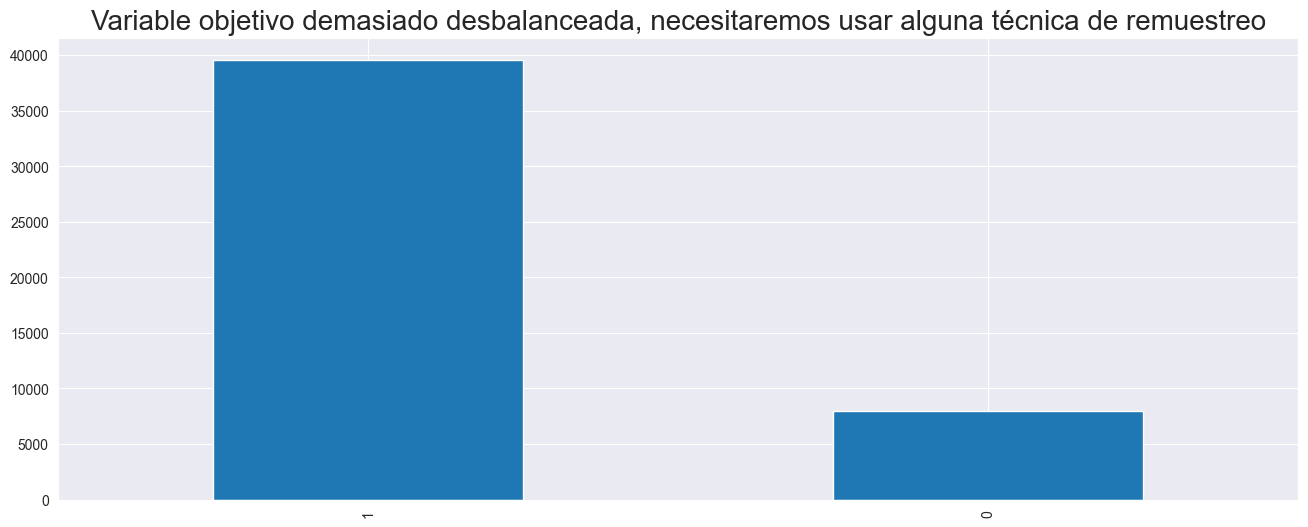

In [60]:
vector_data["cyberbullying"].value_counts().plot(kind="bar",figsize=(16,6))
plt.title("Variable objetivo demasiado desbalanceada, necesitaremos usar alguna técnica de remuestreo",size= 20)
plt.show()

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0,test_size=0.25,stratify=y)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (35644, 38)
y_train shape: (35644,)
X_test shape: (11882, 38)
y_test shape: (11882,)


#### En el notebook de ejemplo se usa SMOTE (Synthetic Minority Over-sampling), técnica que crea muestras sintéticas de la clase minotitaria del dataset. Para no hacer un simple copy paste me estudié un poco la librería y utilizaré la técnica SMOTETomek, esta técnica además de crear muestras sintéticas de la clase minotitaria, aplica también algo de undersampling, la función elimina muestras de la clase mayoritaria que se encuentran cerca (en el espacio n-dimensional del dataset) de la clase minoritaria, haciendo el trabajo de los posteriores clasificadores algo más sencillo.

In [62]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=0)
X_res, y_res = smote_tomek.fit_resample(X_train.toarray(), y_train)


Train Cross-validation mean Accuracy for Naive Bayes: 0.7714
Classification Report on Test set for Naive Bayes:
              precision    recall  f1-score   support

         0.0       0.40      0.80      0.53      1984
         1.0       0.95      0.76      0.85      9898

    accuracy                           0.77     11882
   macro avg       0.68      0.78      0.69     11882
weighted avg       0.86      0.77      0.79     11882

Confusion Matrix on Test set for Naive Bayes:


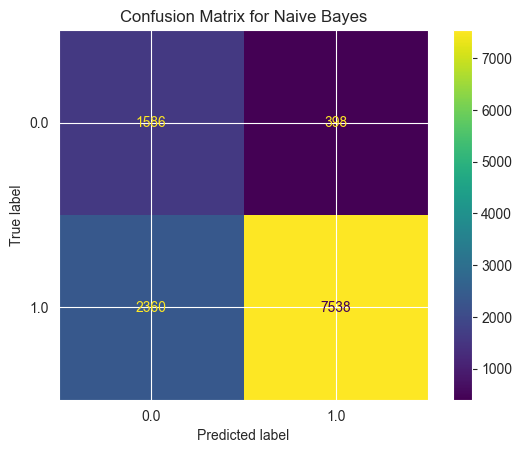

Train Cross-validation mean Accuracy for Logistic Regression: 0.8049
Classification Report on Test set for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.44      0.81      0.57      1984
         1.0       0.95      0.79      0.87      9898

    accuracy                           0.79     11882
   macro avg       0.70      0.80      0.72     11882
weighted avg       0.87      0.79      0.82     11882

Confusion Matrix on Test set for Logistic Regression:


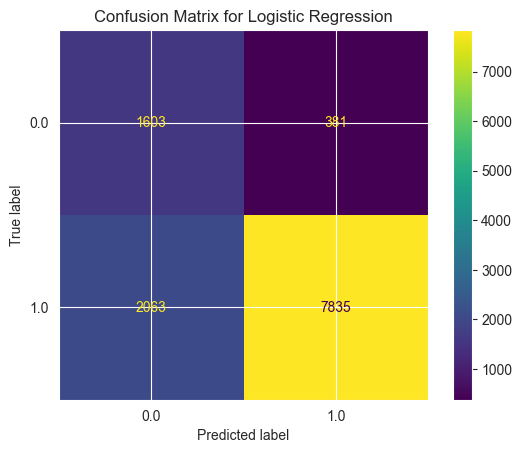

Train Cross-validation mean Accuracy for Random Forest: 0.8785
Classification Report on Test set for Random Forest:
              precision    recall  f1-score   support

         0.0       0.44      0.65      0.53      1984
         1.0       0.92      0.83      0.88      9898

    accuracy                           0.80     11882
   macro avg       0.68      0.74      0.70     11882
weighted avg       0.84      0.80      0.82     11882

Confusion Matrix on Test set for Random Forest:


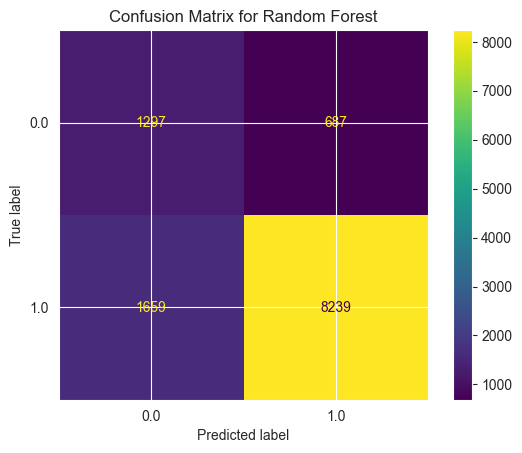

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

classifiers = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_jobs=-1)
}

# Train and evaluate classifiers
for name, classifier in classifiers.items():
    classifier.fit(X_res, y_res)
    
    cv_scores = cross_val_score(classifier, X_res, y_res, cv=4,scoring = "accuracy")
    print(f"Train Cross-validation mean Accuracy for {name}: {round(cv_scores.mean(),4)}")
    
    y_pred = classifier.predict(X_test.toarray())
    print(f"Classification Report on Test set for {name}:")
    print(classification_report(y_test, y_pred))
    
    print(f"Confusion Matrix on Test set for {name}:")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


### El detector de Bullying con mejor accuracy y menor cantidad de Falsos negativos(tomando bullynibg como el caso 1) es el random forest. A continuación un gridseacrh reducido para que pueda correr en un tiempo considerable:

In [64]:
#### Después de un tiempo de espera excesivamente largo, consigo un random forest ligeramente peor

In [65]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
#Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 150}

rf_classifier = RandomForestClassifier()


param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    'n_estimators': [100, 150],
    'max_depth': [None, 20],
    "max_features": ["sqrt", "log2", None],
}


grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=4, n_jobs=-1,verbose=1)
grid_search.fit(X_res.toarray(), y_res)

print("Best Parameters:", grid_search.best_params_)


y_pred = grid_search.predict(X_test.toarray())
print("Classification Report on test for best random forest found:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.title('Confusion Matrix on test for best random forest found:')
plt.show()
"""

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\n#Best Parameters: {\'criterion\': \'gini\', \'max_depth\': None, \'max_features\': \'log2\', \'n_estimators\': 150}\n\nrf_classifier = RandomForestClassifier()\n\n\nparam_grid = {\n    "criterion": ["gini", "entropy", "log_loss"],\n    \'n_estimators\': [100, 150],\n    \'max_depth\': [None, 20],\n    "max_features": ["sqrt", "log2", None],\n}\n\n\ngrid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=4, n_jobs=-1,verbose=1)\ngrid_search.fit(X_res.toarray(), y_res)\n\nprint("Best Parameters:", grid_search.best_params_)\n\n\ny_pred = grid_search.predict(X_test.toarray())\nprint("Classification Report on test for best random forest found:")\nprint(classification_report(y_test, y_pred))\n\ncm = confusion_matrix(y_test, y_pred)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)\ndisp.plot()\nplt.title(\'Confusion Matrix on t

### Es difícil interpretar un modelo de machine learning como un random forest, pero un paquete muy útil (aunque defectuoso) es SHAP, SHAP calcula la importancia de los parámetros de un modelo de aprendizaje automátoca con una perspectiva de teoría de juegos, concretamente calcula los valores SHAPLEY, su beeswarm plot es especialmente bueno.

### Pero como digo es muy defectuoso https://pypi.org/project/shap/ 1369 open issues. Gracias a Dios se le está dando mucho mantenimiento últimamente e incluso se incorporaron nuevos plots, pero surgen problemas de vez en cuando como el que muestro a continuación.

In [66]:
rf_classifier = RandomForestClassifier(n_jobs=-1)# Lo vuelvo a instanciar sin parámetros
rf_classifier.fit(X_res, y_res)

RandomForestClassifier(n_jobs=-1)

In [67]:
import shap 
X_res_summary = shap.kmeans(X_res, 100)
explainer = shap.KernelExplainer(rf_classifier.predict,X_res_summary)

In [68]:
shap_values = explainer.shap_values(X_test[0:100])

  0%|          | 0/100 [00:00<?, ?it/s]

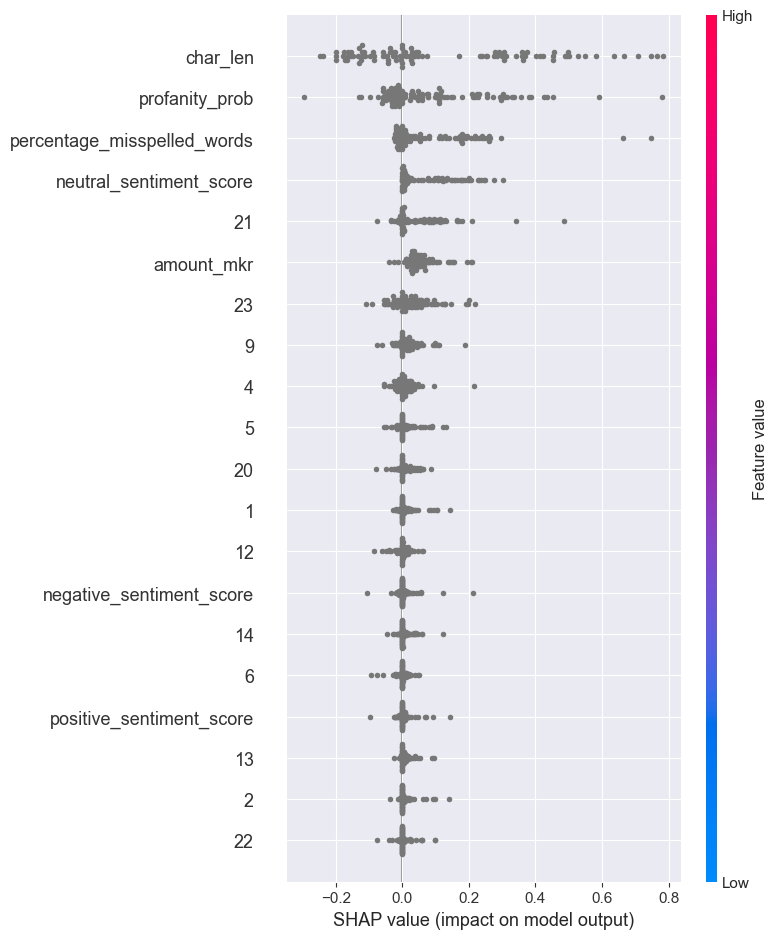

In [69]:
shap.summary_plot(shap_values, X_test[0:100],feature_names=vector_data.drop("cyberbullying",axis=1).columns,
                  color=plt.get_cmap("cool"))

# SHAP tiene muchos fallos, este se tiene desde 2019 reportado "https://github.com/shap/shap/issues/406"
# en el github dice el creador que se solucionó el problema, pero en 2021 este usuario de stackoverflow no recibió respuesta:
#https://stackoverflow.com/questions/68620866/why-is-my-shap-plot-in-python-returning-grey-instead-of-red-and-blue

# Se puede ver feature importance, pero no si afecta positiva o negativamente. Parece que las features que creé influyen mucho al modelo.


## Para finalizar el notebook escribo esta función que permite realizar validación cruzada aleatoria en muestras que fueron resampled. Los resultados de un simple KFoldCrossValidation en una muestra resampled no son de fiar, pues hacen el test también sobre la muestra resampled, con la función a continuación se hace el test sobre los datos tal cual como son.

In [70]:
from imblearn.under_sampling import RandomUnderSampler,NearMiss,TomekLinks, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN,BorderlineSMOTE,SVMSMOTE, KMeansSMOTE
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def muchos_train_test_resampled(X,y,modelo,n=20, resampling="SMOTETomek",seed=123,title=False,sampling_strategy="auto",tipo = "True_PosNeg_Rate"):
    """
    Para que no haya confusión, así defino la matriz:  [[TP,FN],
                                                        [FP, TN]]   
    True rate: de todos los true values cuántos identifico.
    """
    rng = np.random.default_rng(seed)
    TP= 0 
    FP = 0
    FN = 0
    TN = 0 
    TP_rate = []
    TN_rate = []
    Accuracy = []
    F1_Score = []
    if resampling== "SMOTETomek":
        resampler = SMOTETomek(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "RandomUnderSampler":
        resampler = RandomUnderSampler(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "ADASYN":
        resampler = ADASYN(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "SMOTE":
        resampler = SMOTE(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "BorderlineSMOTE":
        resampler = BorderlineSMOTE(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "SVMSMOTE":
        resampler = SVMSMOTE(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "KMeansSMOTE":
        resampler = KMeansSMOTE(random_state=rng.integers(1000000),sampling_strategy = sampling_strategy)
    elif resampling== "NearMiss":
        resampler = NearMiss(version=2)
    elif resampling== "TomekLinks":
        resampler = TomekLinks(sampling_strategy = "majority")
    elif resampling== "EditedNearestNeighbours":
        resampler = EditedNearestNeighbours(random_state=rng.integers(1000000))
   
    for i in range(n):
        seed = rng.integers(1000000)
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed, test_size=0.2,stratify=y)
        X_train_st, y_train_st = resampler.fit_resample(X_train, y_train)
        modelo.fit(X_train_st,y_train_st)
        y_pred = modelo.predict(X_test)
        matriz_confusion = confusion_matrix(y_test, y_pred)

        TP += matriz_confusion[0][0]
        TP_rate_iteracion = (matriz_confusion[0][0])/(matriz_confusion[0][0]+ matriz_confusion[0][1])
        TP_rate.append(TP_rate_iteracion)
        FP += matriz_confusion[0][1]
        FN += matriz_confusion[1][0]
        TN += matriz_confusion[1][1]
        TN_rate_iteracion = (matriz_confusion[1][1])/(matriz_confusion[1][1]+ matriz_confusion[1][0])
        TN_rate.append(TN_rate_iteracion)

        Accuracy.append(accuracy_score(y_true=y_test,y_pred=y_pred))
        F1_Score.append(f1_score(y_true=y_test,y_pred=y_pred,pos_label=0))

    TP /= n
    FP /= n
    FN /= n
    TN /= n  

    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (30,6))
    fig.suptitle(f"{type(modelo).__name__}+ {resampling} k_fold {n}",fontsize = 20)

    mat=np.array([[int(TP),int(FP)],[int(FN),int(TN)]])
    ax1.set_title("Matriz de confusión", fontsize=30)
    sns.heatmap(mat,cmap="coolwarm",annot=True, fmt='g',ax=ax1)

    if tipo == "True_PosNeg_Rate":
        #ax2
        ax2.set_title("Sesgo-Varianza del True Positive Rate", fontsize=25)
        mean1 = pd.Series(TP_rate).mean()
        std_dev1 = pd.Series(TP_rate).std()
        ax2.annotate(f"Valor medio: {mean1:.4f}", xy=(0.5, 0.96), xycoords='axes fraction', ha='center', fontsize=16)
        ax2.annotate(f"Desviación estándar: {std_dev1:.4f}", xy=(0.5, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
        sns.violinplot(pd.Series(TP_rate),orient="v",inner="box", width=0.65,ax=ax2)
        #ax3
        ax3.set_title("Sesgo-Varianza del True Negative Rate", fontsize=25)
        mean2 = pd.Series(TN_rate).mean()
        std_dev2 = pd.Series(TN_rate).std()
        ax3.annotate(f"Valor medio: {mean2:.4f}", xy=(0.5, 0.96), xycoords='axes fraction', ha='center', fontsize=16)
        ax3.annotate(f"Desviación estándar: {std_dev2:.4f}", xy=(0.5, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
        sns.violinplot(pd.Series(TN_rate),orient="v",inner="box", width=0.65,ax=ax3)


    elif tipo == "Accuracy_F1":
        #ax2
        ax2.set_title("Sesgo-Varianza del Accuracy", fontsize=25)
        mean1 = pd.Series(Accuracy).mean()
        std_dev1 = pd.Series(Accuracy).std()
        ax2.annotate(f"Valor medio: {mean1:.4f}", xy=(0.5, 0.96), xycoords='axes fraction', ha='center', fontsize=16)
        ax2.annotate(f"Desviación estándar: {std_dev1:.4f}", xy=(0.5, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
        sns.violinplot(pd.Series(Accuracy),orient="v",inner="box", width=0.65,ax=ax2)
        #ax3
        ax3.set_title("Sesgo-Varianza del F1 Score", fontsize=25)
        mean2 = pd.Series(F1_Score).mean()
        std_dev2 = pd.Series(F1_Score).std()
        ax3.annotate(f"Valor medio: {mean2:.4f}", xy=(0.5, 0.96), xycoords='axes fraction', ha='center', fontsize=16)
        ax3.annotate(f"Desviación estándar: {std_dev2:.4f}", xy=(0.5, 0.90), xycoords='axes fraction', ha='center', fontsize=16)
        sns.violinplot(pd.Series(F1_Score),orient="v",inner="box", width=0.65,ax=ax3)

    plt.show()

rf_classifier = RandomForestClassifier(n_jobs=-1)

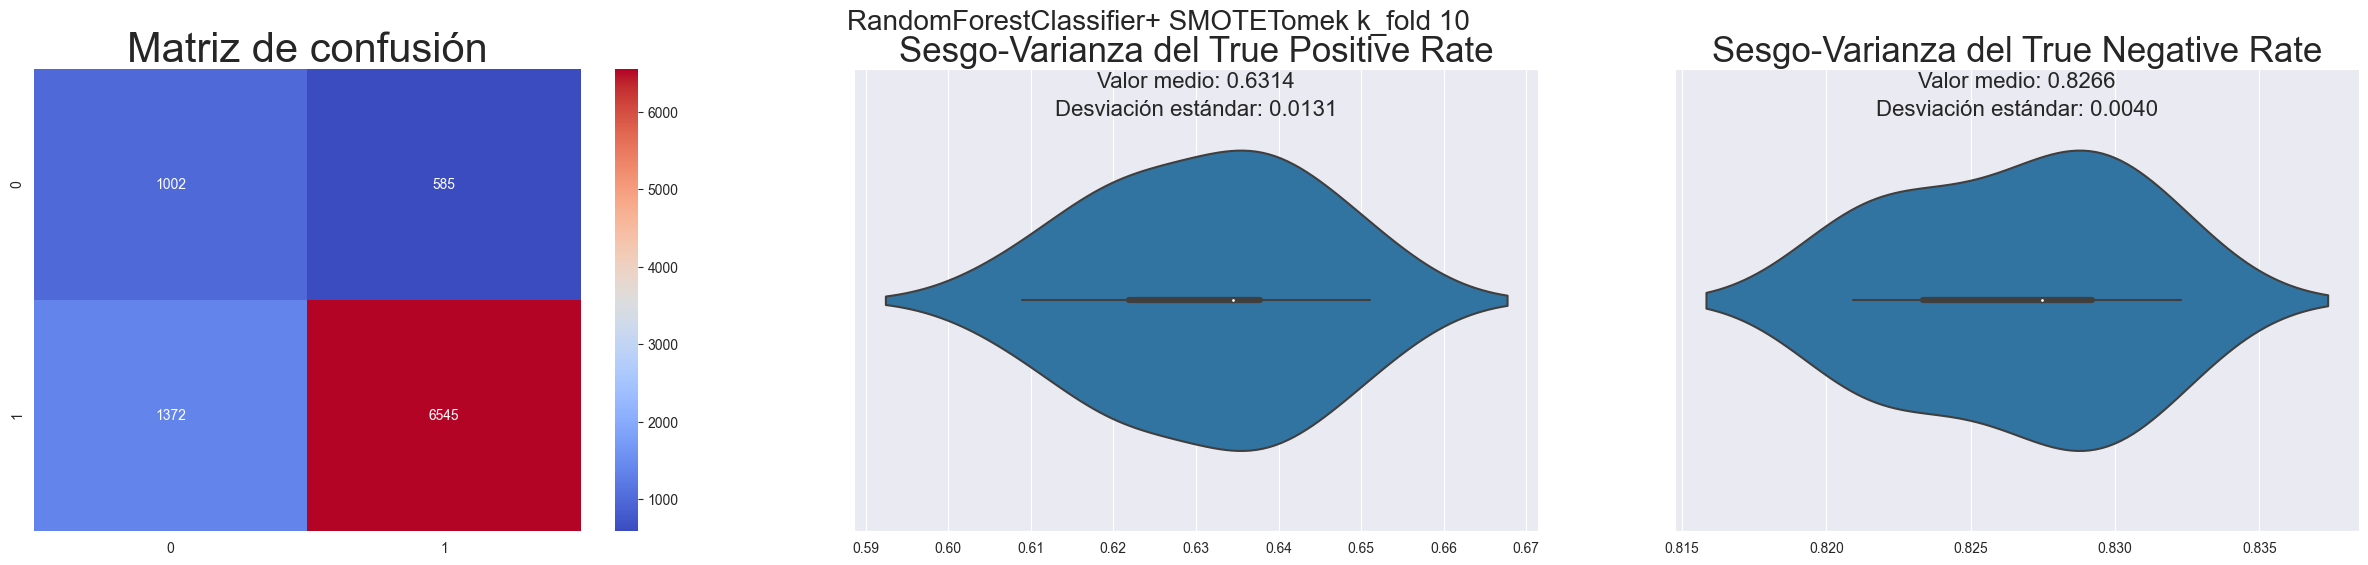

In [71]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="SMOTETomek",seed=123)
plt.show()

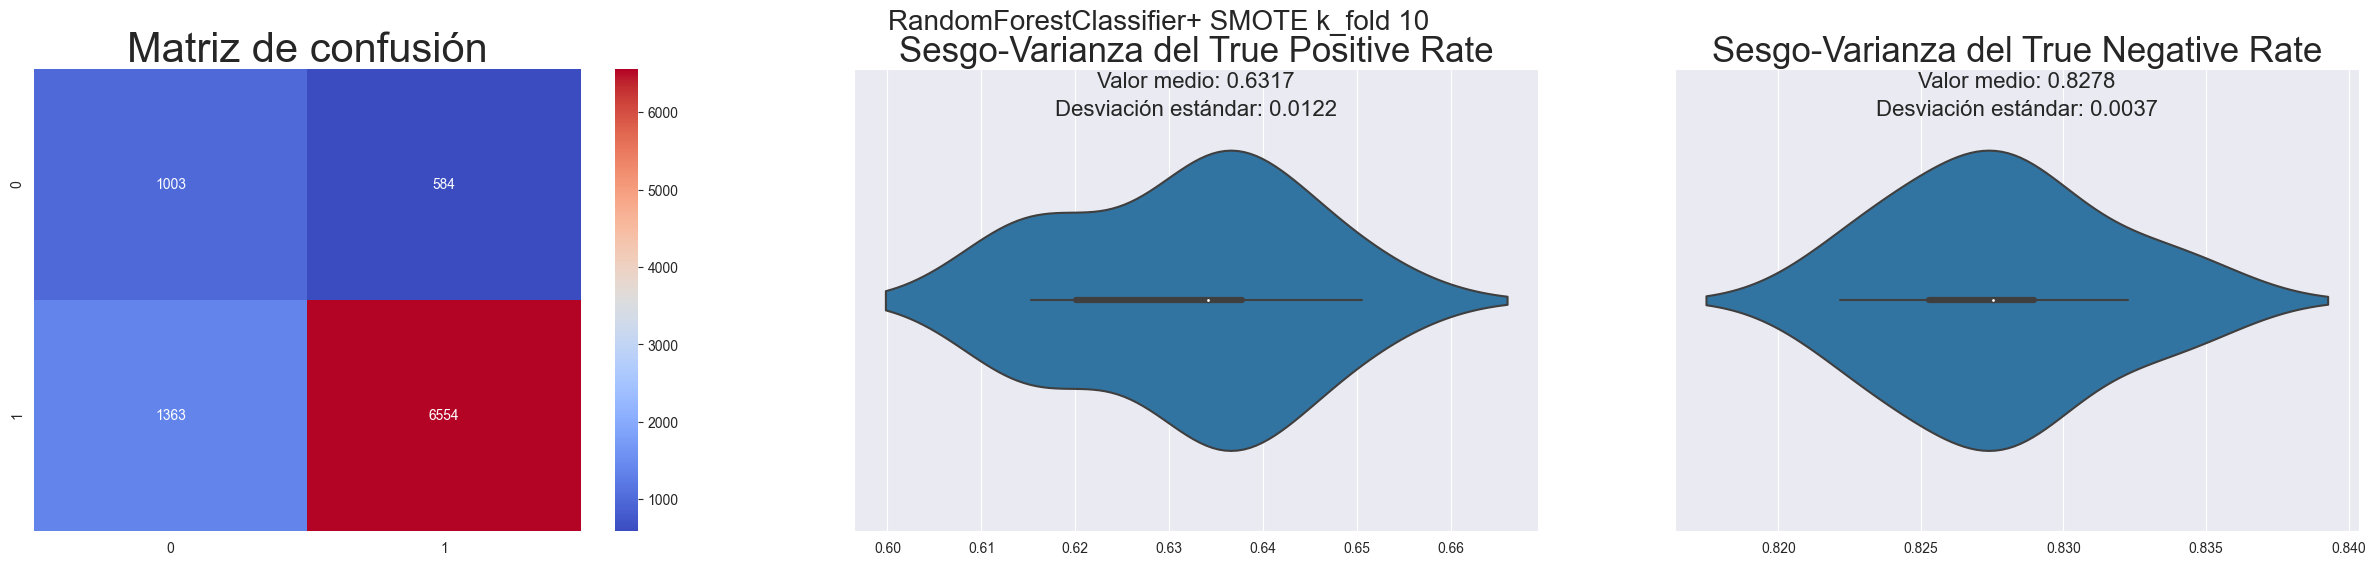

In [72]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="SMOTE",seed=123)
plt.show()

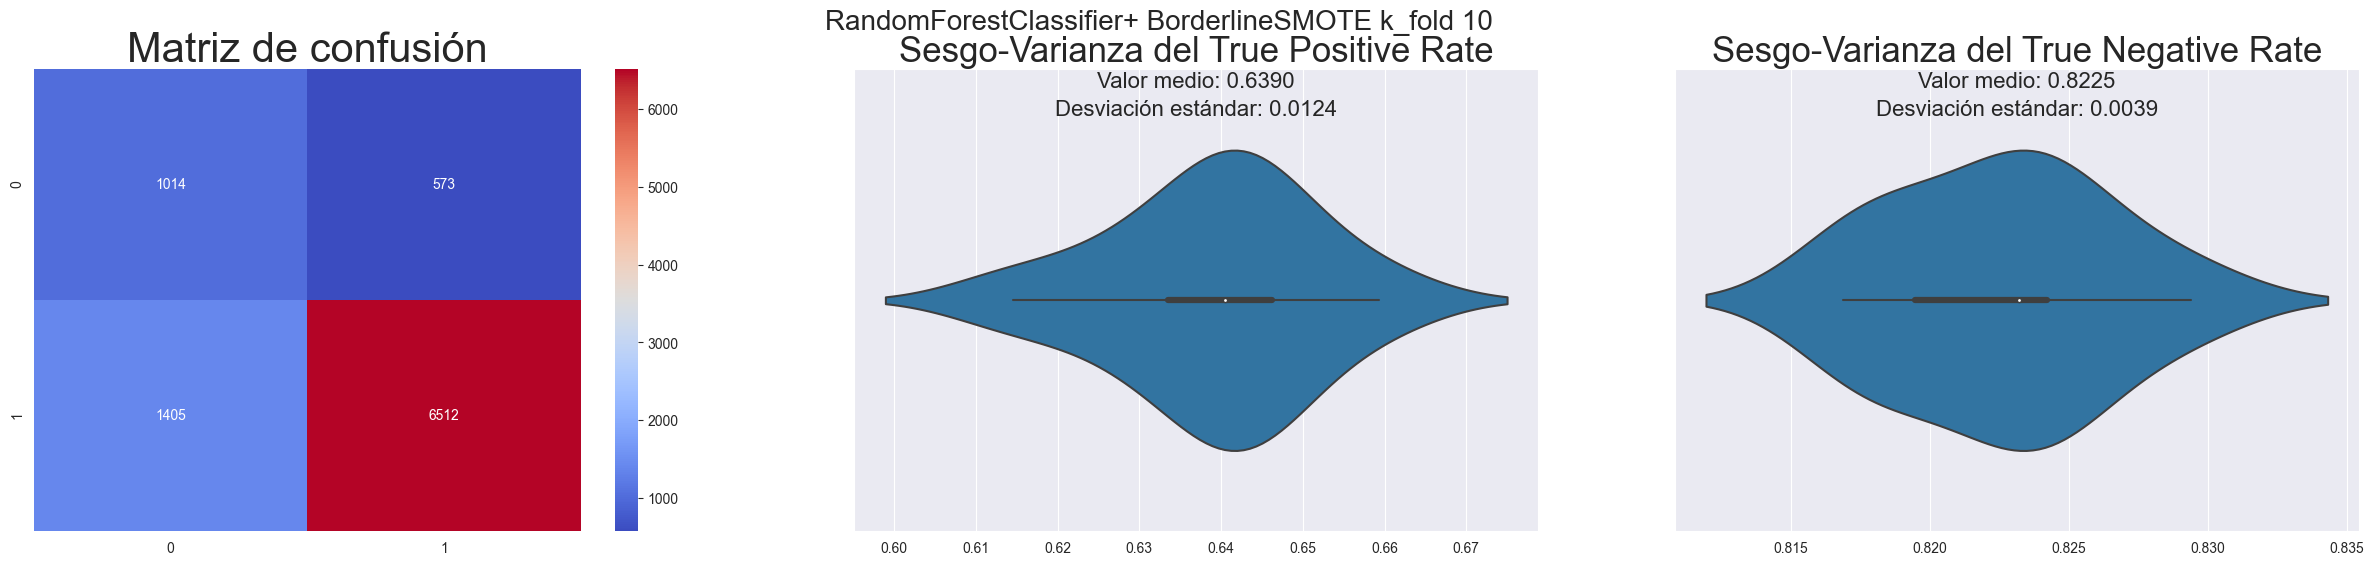

In [73]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="BorderlineSMOTE")
plt.show()


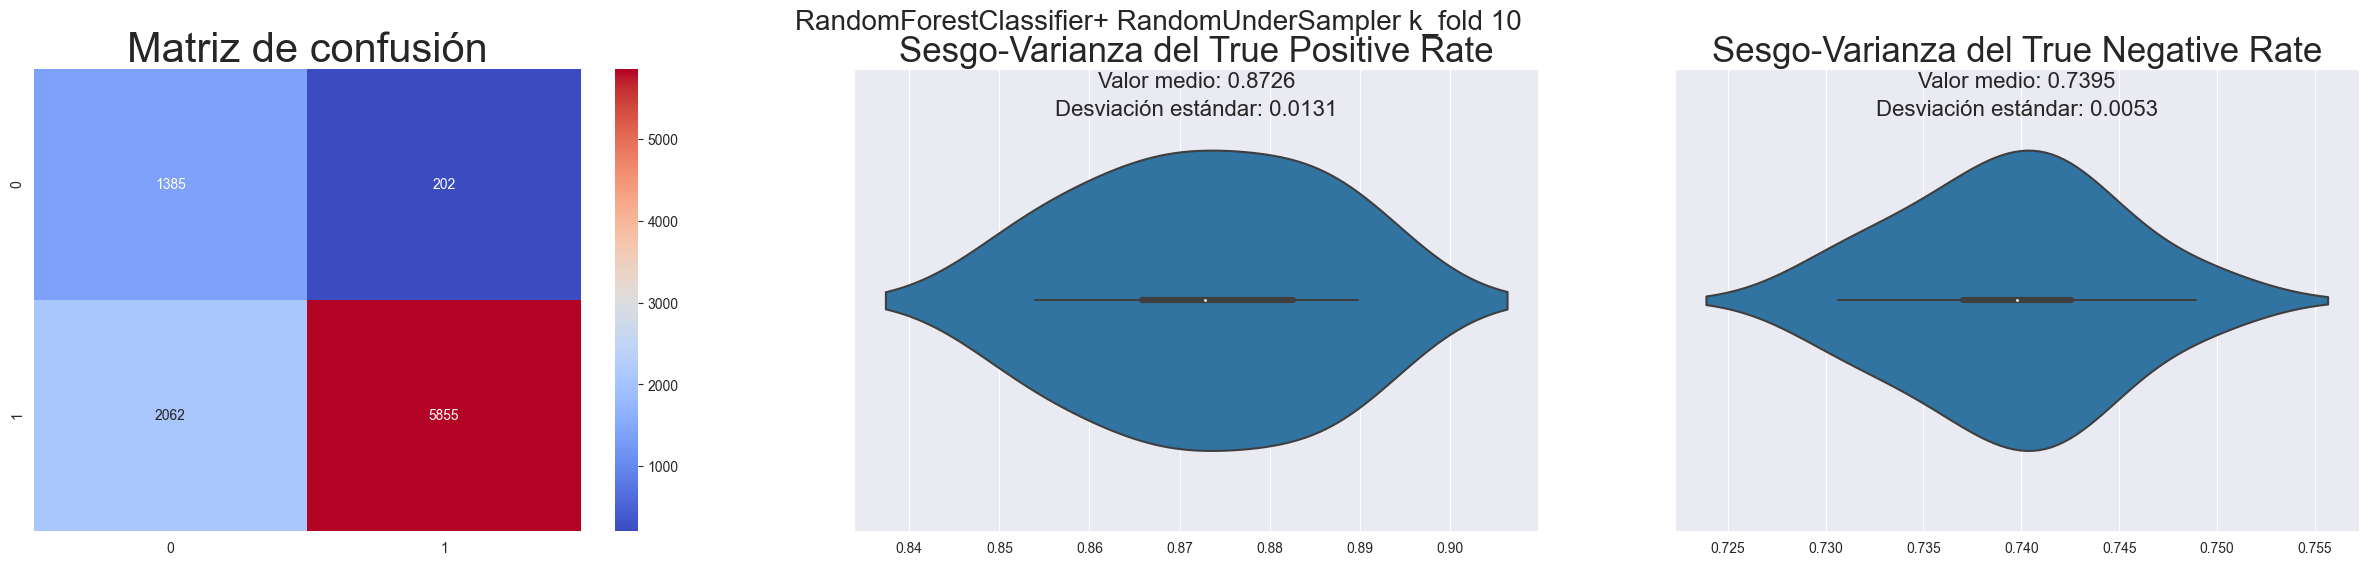

In [74]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="RandomUnderSampler",seed=123)
plt.show()

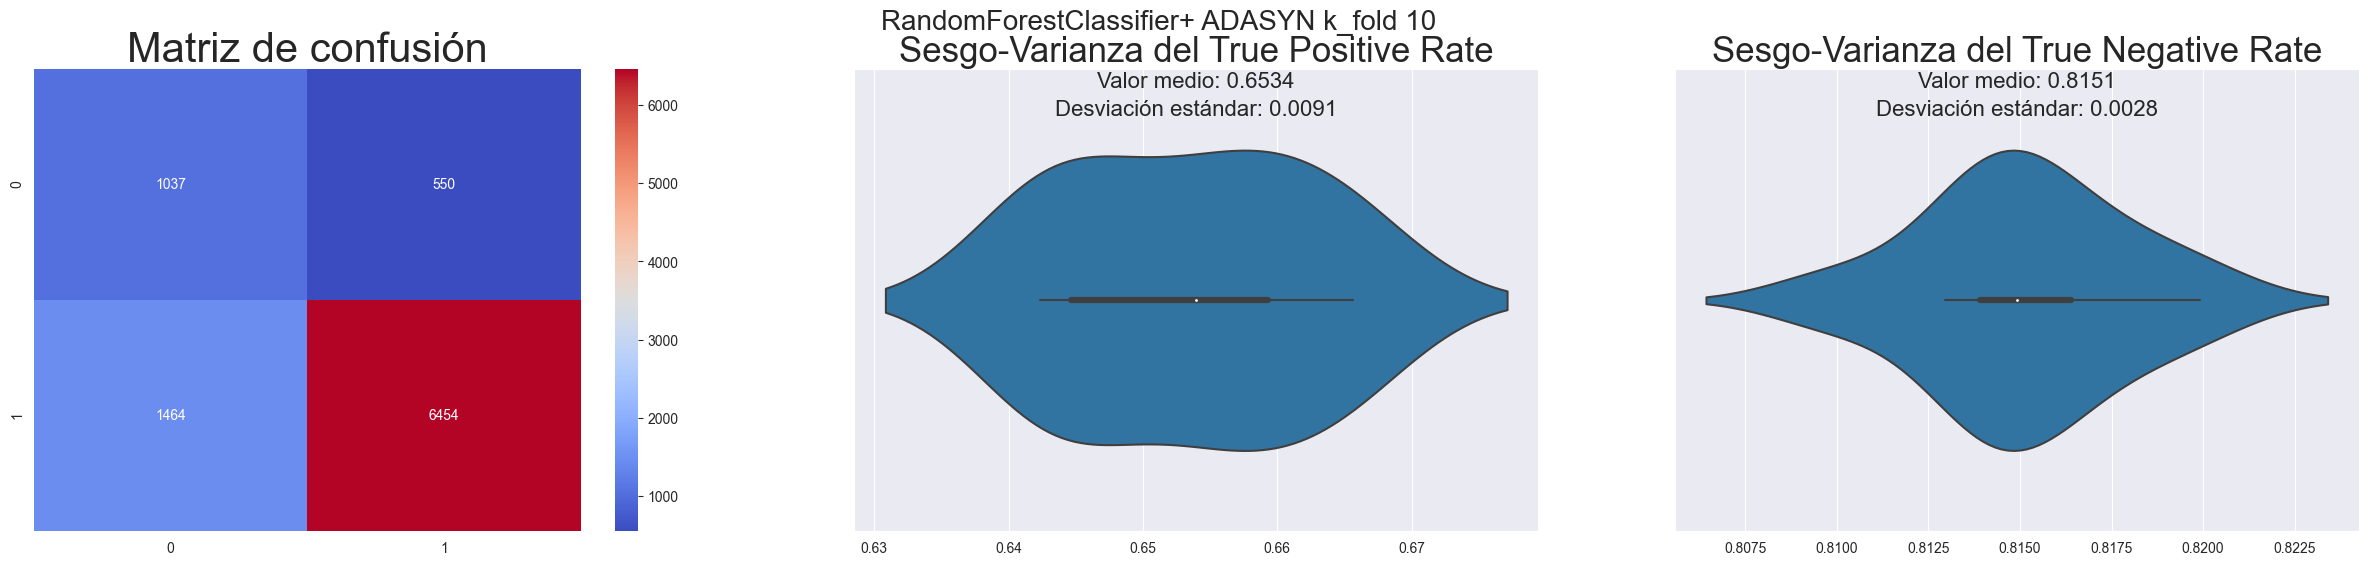

In [75]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="ADASYN",seed=123)
plt.show()

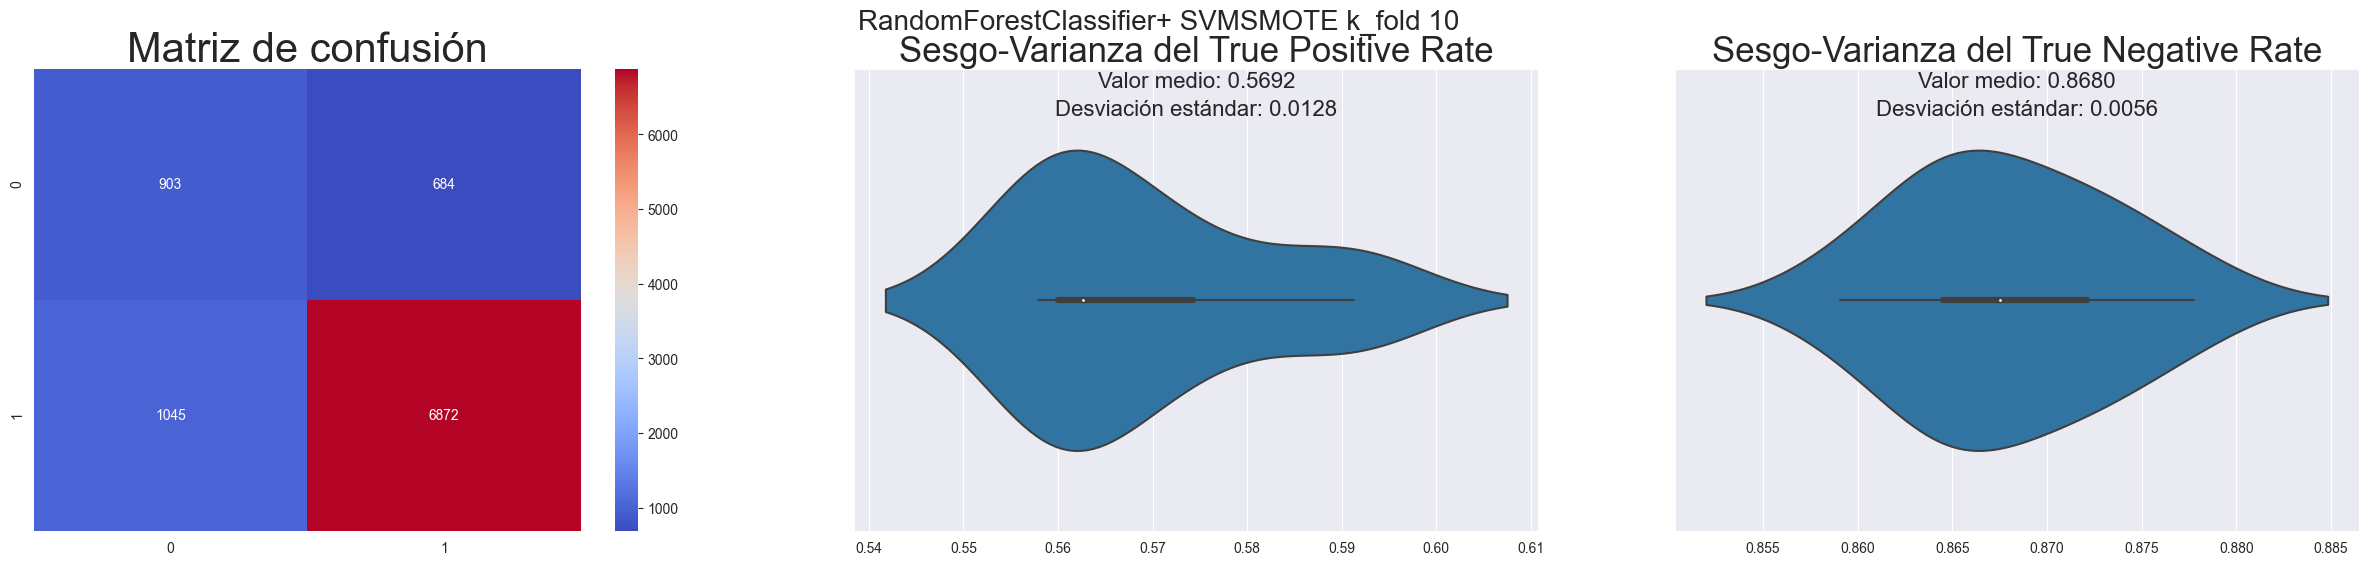

In [76]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="SVMSMOTE",seed=123)
plt.show()

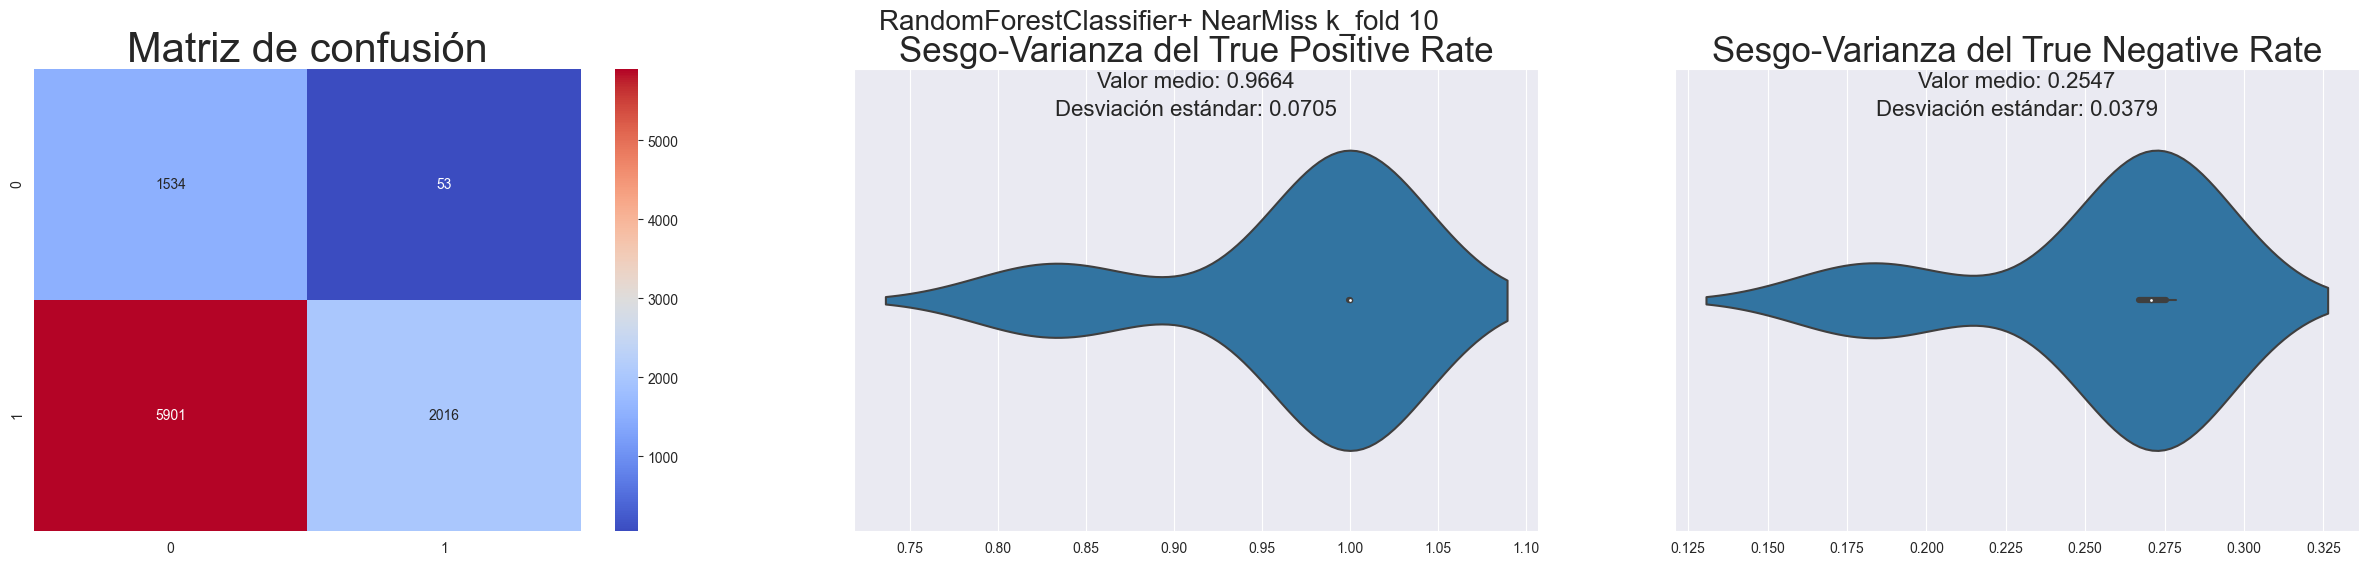

In [77]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="NearMiss",seed=123)
plt.show()

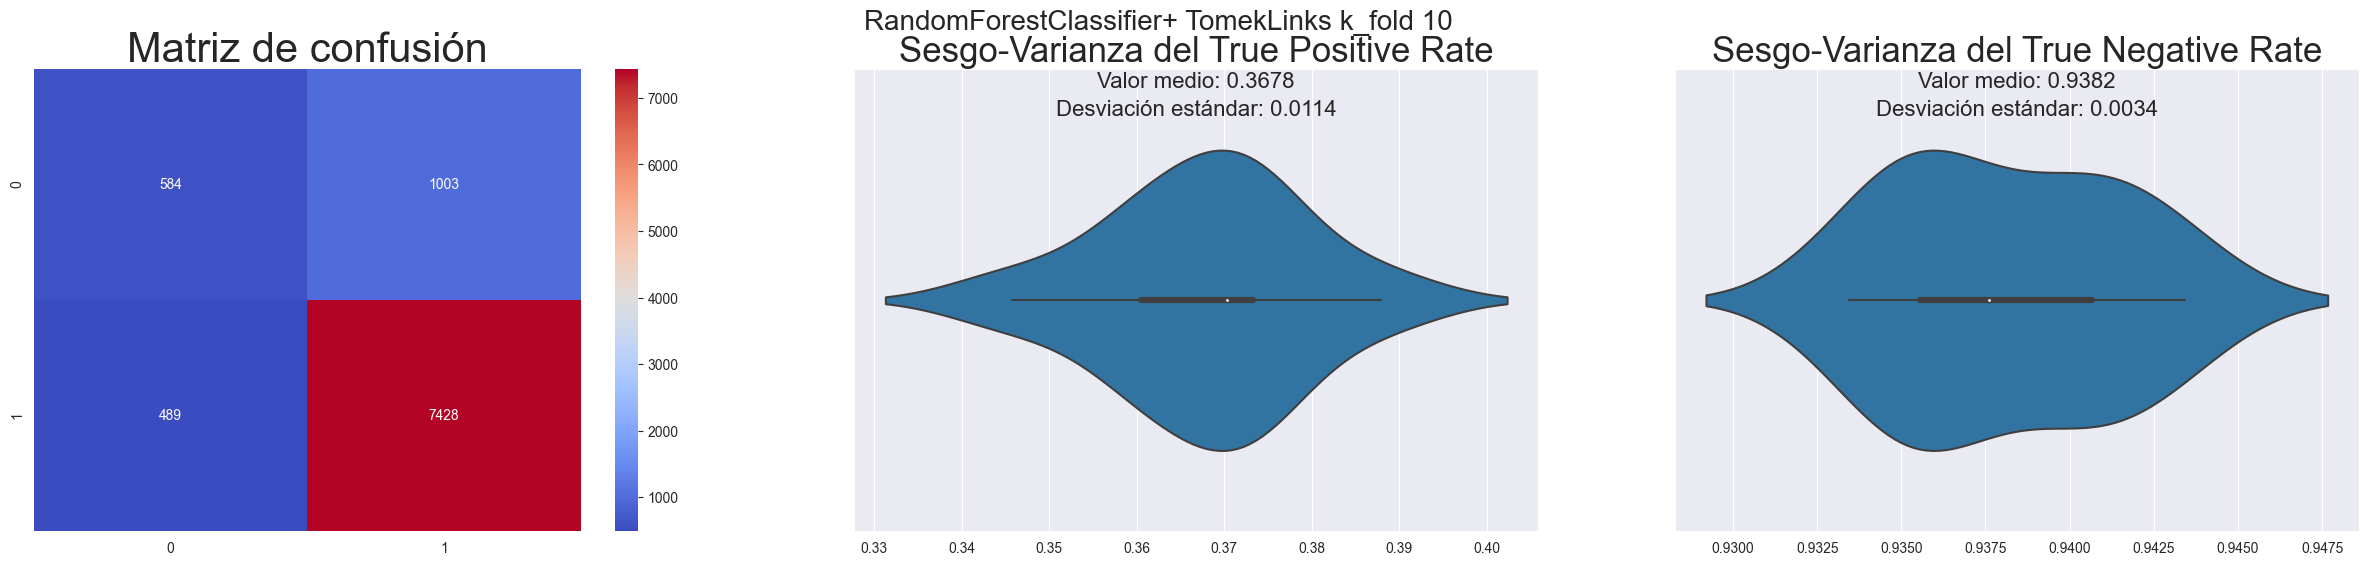

In [78]:
muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="TomekLinks",seed=123)
plt.show()

# De aquellos probados en esta validación cruzada el SMOTE normal da los mejores resultados, para hacer el estudio más comprensivo intentaré distintos sampling strategies sobre la técnica SMOTE

1


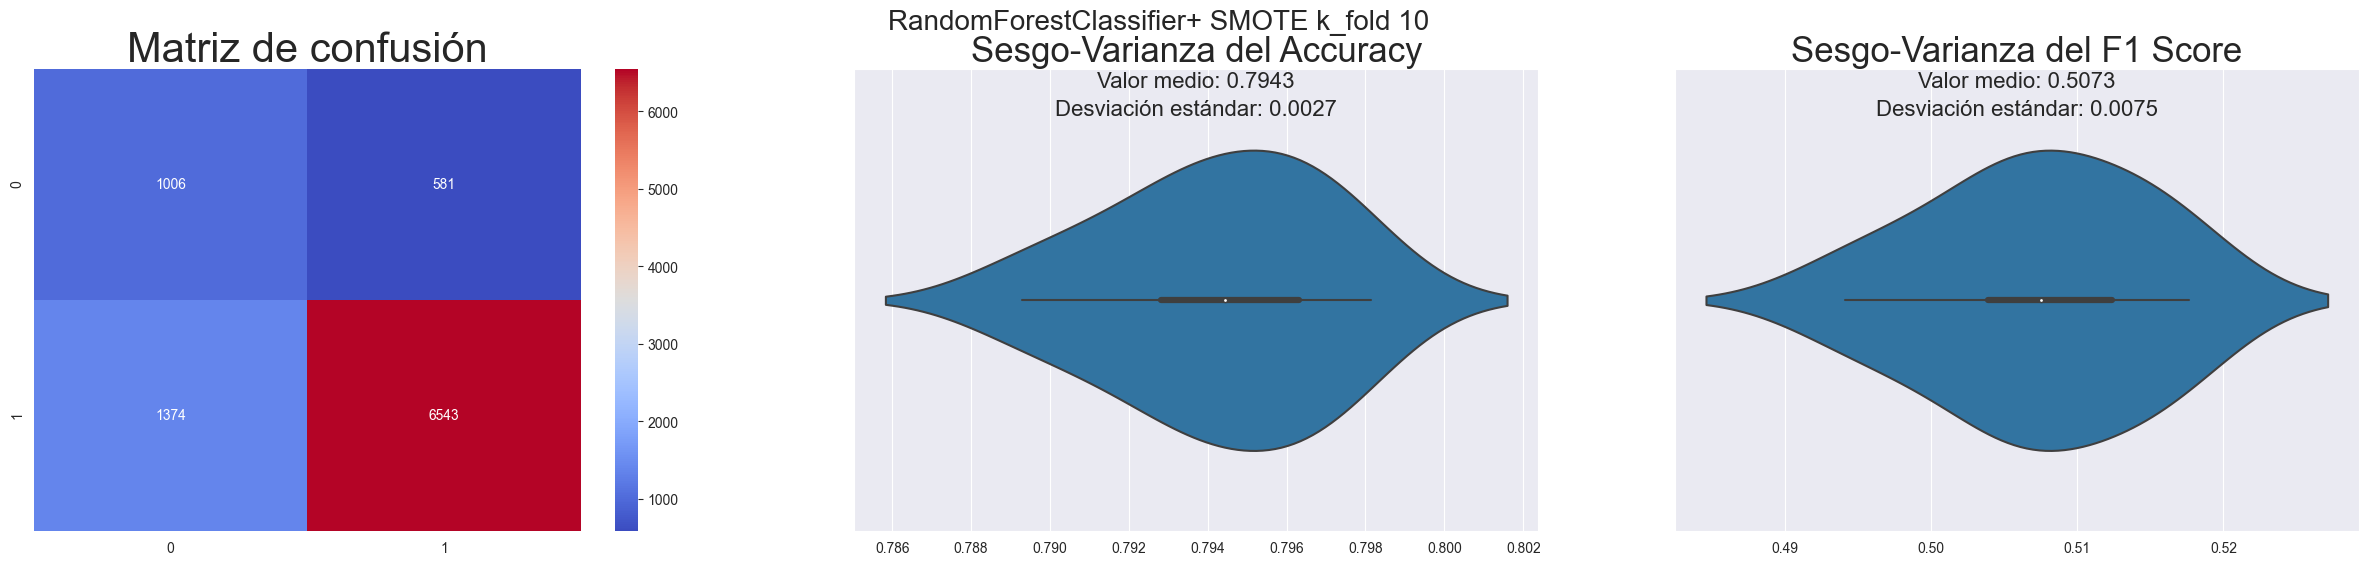

0.8


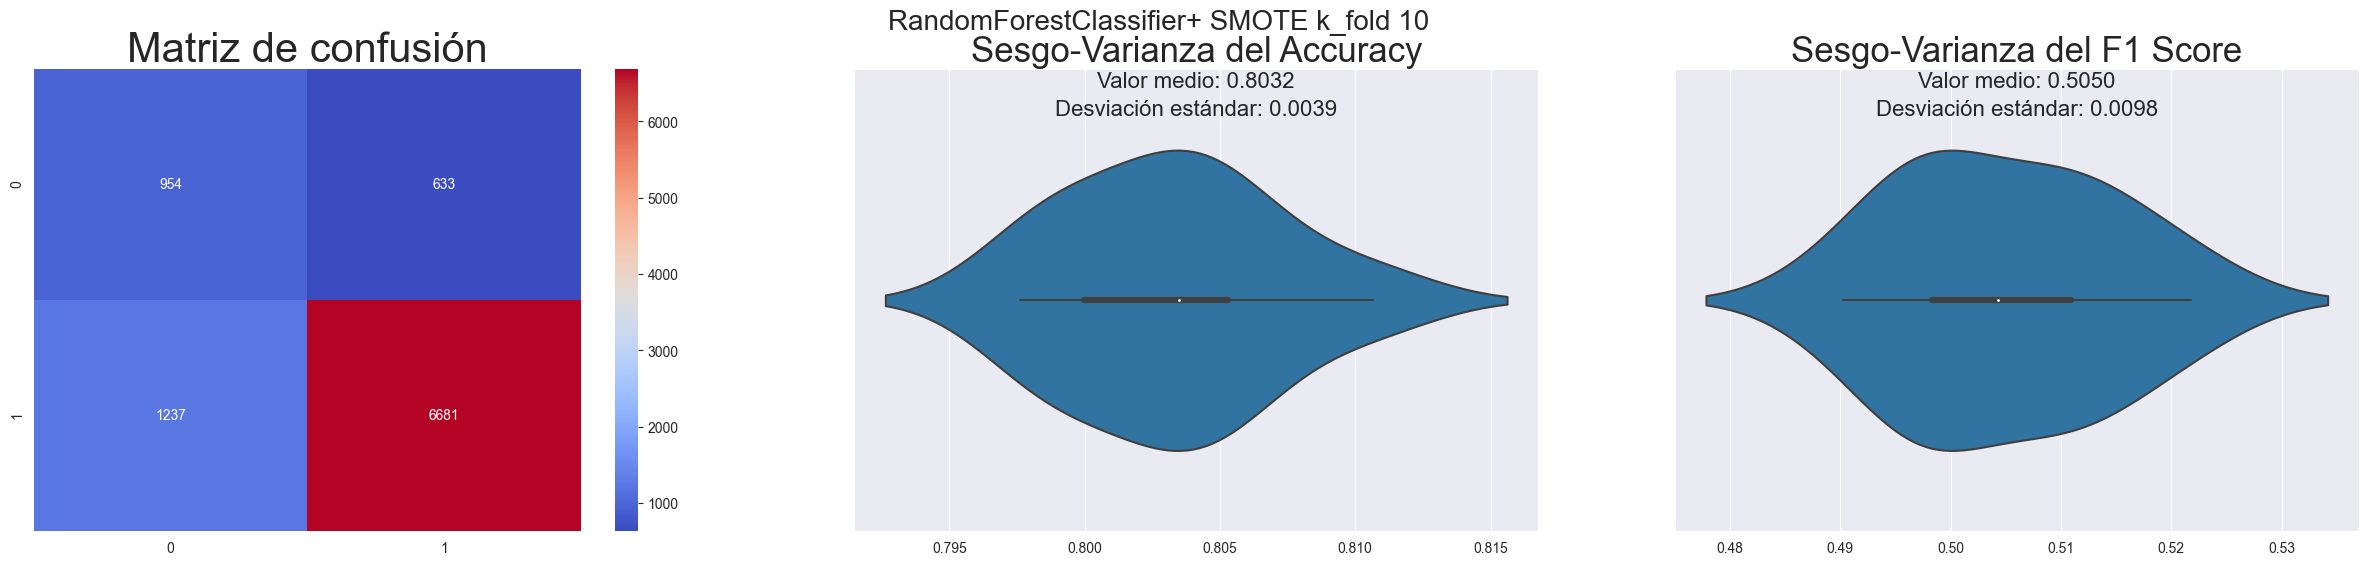

0.6


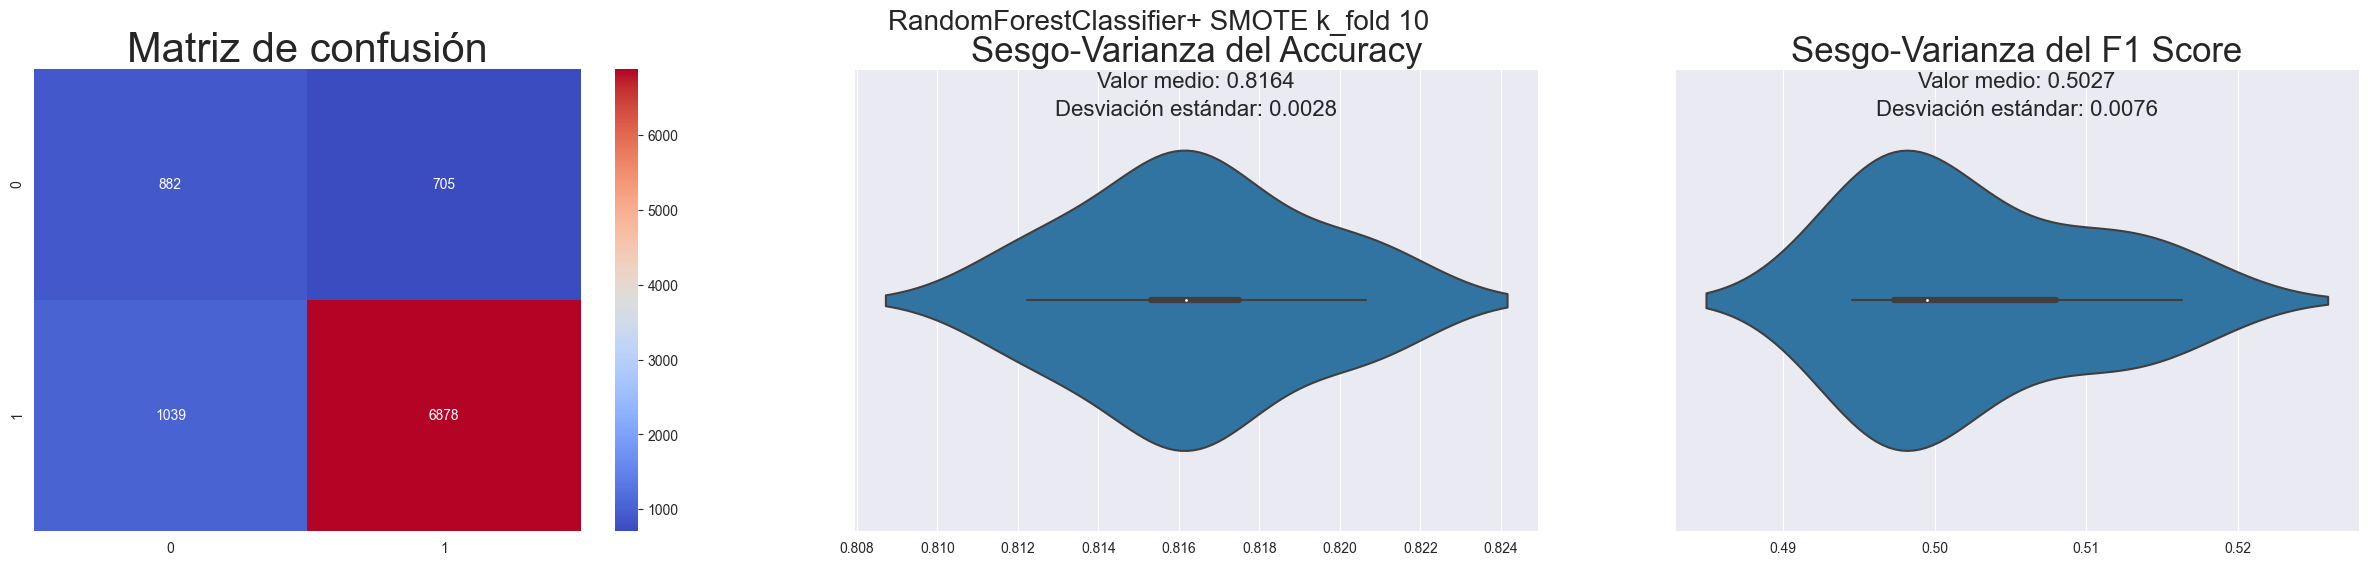

0.4


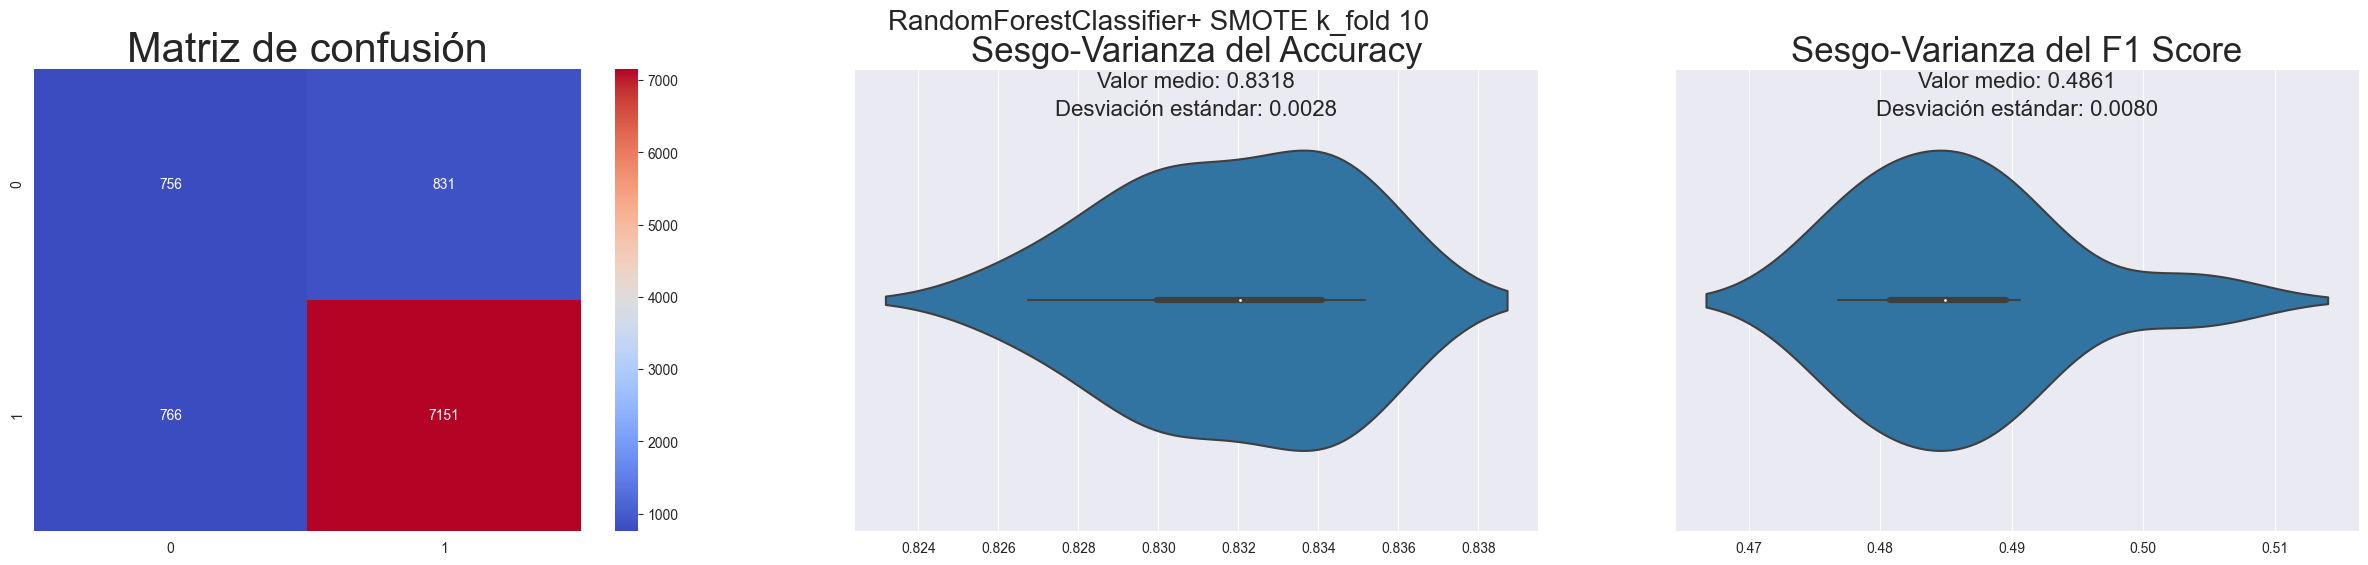

In [79]:
for i in [1,0.8,0.6,0.4]:
    print(i)
    muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="SMOTE",seed=123,
                                sampling_strategy=i,tipo="Accuracy_F1")
    plt.show()

### Para mí la mejor estartegia sigue siendo la que escoge ImbLearn por default (rebalanceo completo). El Random Forest consigue muy buenas métriucas con la clase mayoritaria aún con un rebalanceo completo. Sí es cierto que al cambiar el sampling strategy a 0.8 se sacrifica poco acierto en la clase mayoritaria y se gana algo más significativo en la minoritaria (aumentando el F1), pero a mi parecer ya el programa tiene suficientes problemas prediciendo 0s y se le debe ayudar lo máximo que se pueda. Si nos queremos guiar por una métrica más objetiva que mi simple parecer, eligiría el modelo con sampling strategy 0.8.

### Igualmente volveré a intentar con sampling strategies centrados en 0.8.

0.95


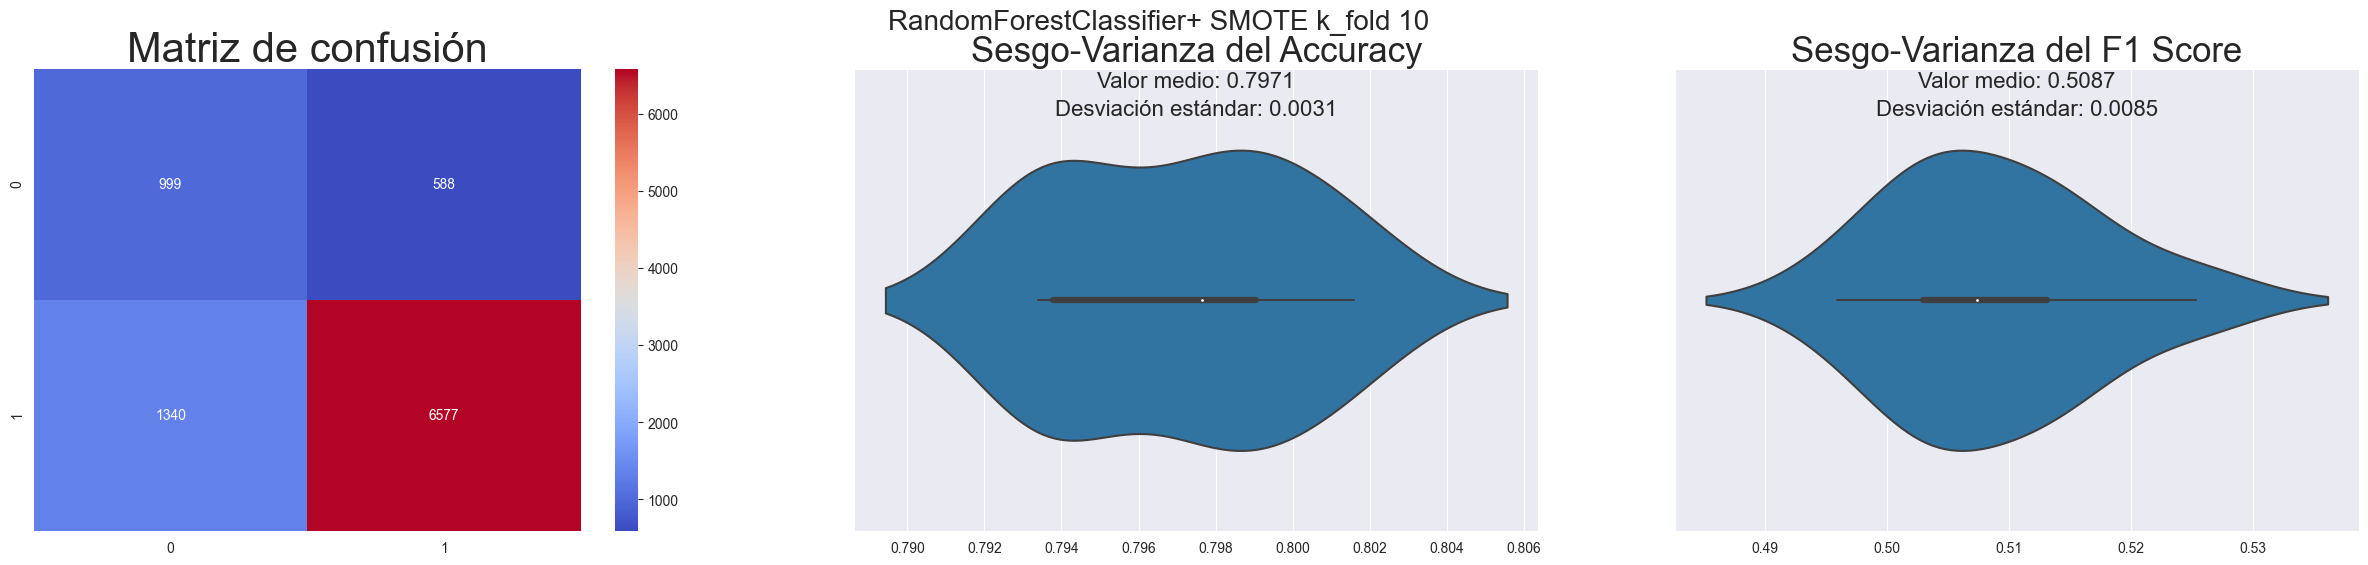

0.9


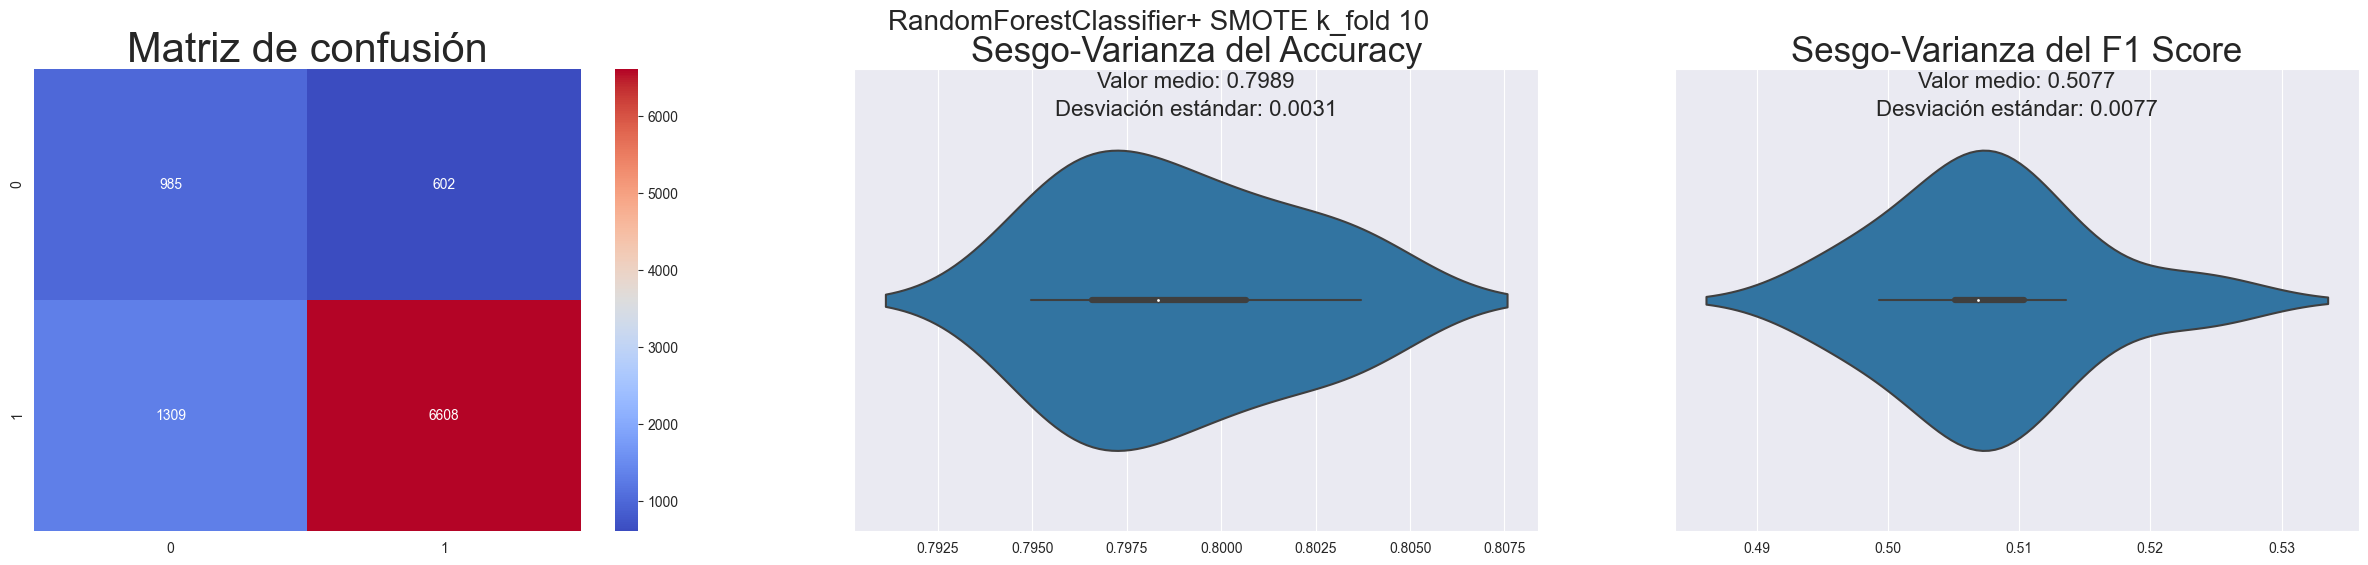

0.85


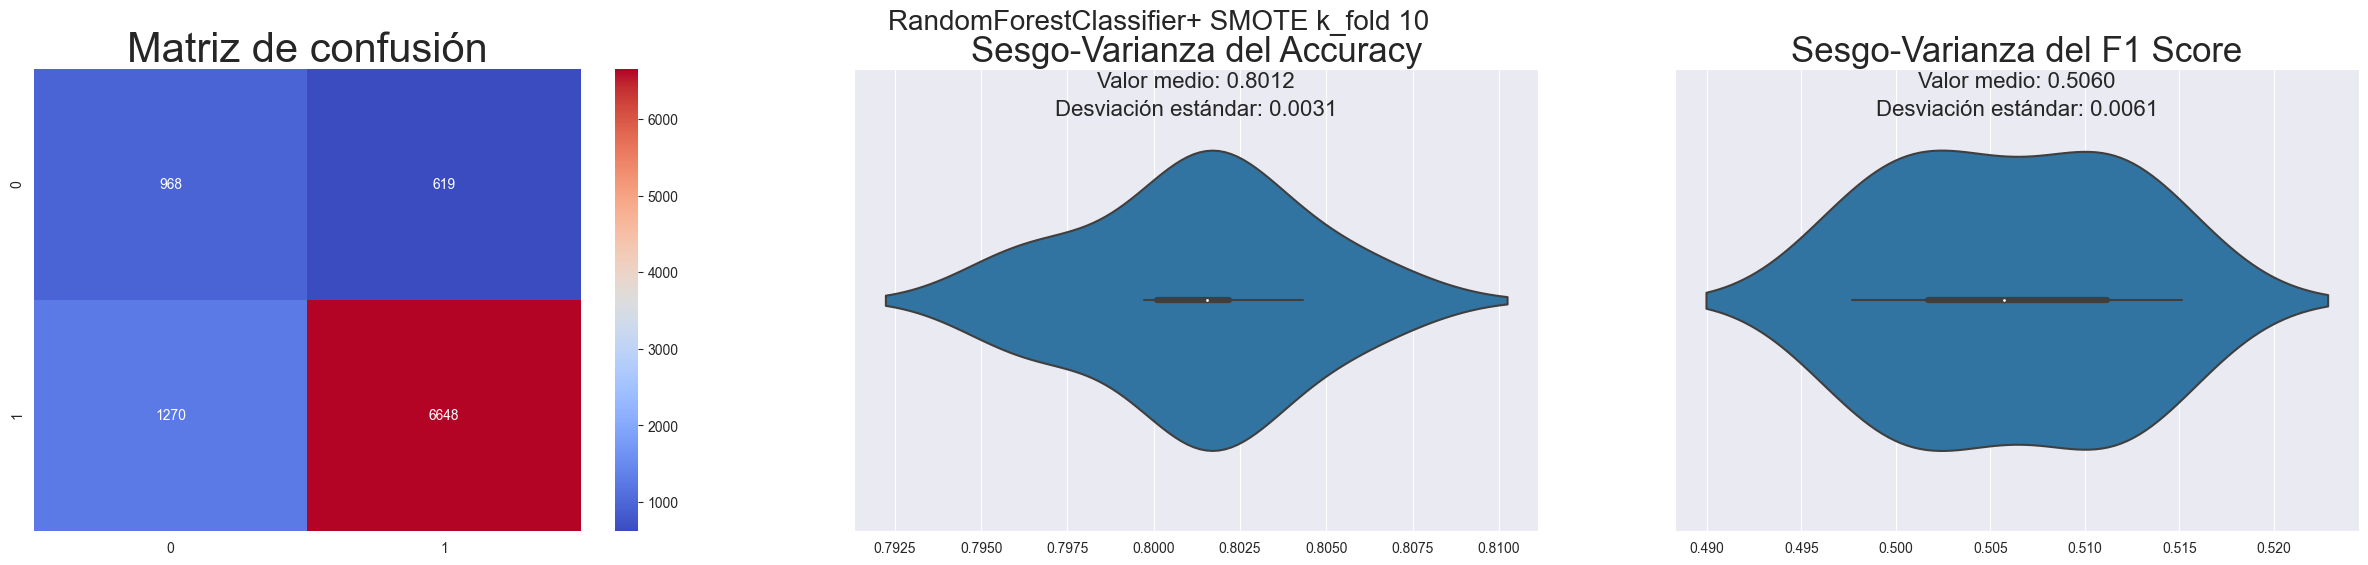

In [80]:
for i in [0.95,0.90,0.85]:
    print(i)
    muchos_train_test_resampled(X.toarray(),y,rf_classifier,n=10, resampling="SMOTE",seed=123,
                                sampling_strategy=i,tipo="Accuracy_F1")
    plt.show()

## Dependiendo de nuestro caso de uso y de la importancia que le depositemos a cada error eligiremos una estrategia u otra. Mi preferencia a priori es samplingstrategy = 0.95 porque maximiza el F1. 